In [24]:
churn_features_df

shape: (28_136, 47)
┌────────────┬───────────┬─────────┬─────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ CLIENT_ID_ ┆ HAS_EMAIL ┆ HAS_SMS ┆ HAS_VKL ┆ … ┆ FUEL_TRANS ┆ NON_FUEL_T ┆ AVG_FUEL_ ┆ RECENT_FU │
│ SAP        ┆ ---       ┆ ---     ┆ ---     ┆   ┆ ACTION_PER ┆ RANSACTION ┆ LITERS_PE ┆ EL_PURCHA │
│ ---        ┆ i8        ┆ i8      ┆ i8      ┆   ┆ CENTAGE    ┆ _PERCENTAG ┆ R_TRANSAC ┆ SE_TREND  │
│ u32        ┆           ┆         ┆         ┆   ┆ ---        ┆ …          ┆ TIO…      ┆ ---       │
│            ┆           ┆         ┆         ┆   ┆ f64        ┆ ---        ┆ ---       ┆ f64       │
│            ┆           ┆         ┆         ┆   ┆            ┆ f64        ┆ f64       ┆           │
╞════════════╪═══════════╪═════════╪═════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 7713274081 ┆ 1         ┆ 1       ┆ 1       ┆ … ┆ 97.142857  ┆ 17.142857  ┆ 37.065588 ┆ 0.705882  │
│ 8813338581 ┆ 1         ┆ 1       ┆ 1       ┆ … ┆ 90.0       ┆ 40.0       ┆ 29.444444 ┆ 0.666667  │
│ 7712459552 ┆ 1         ┆ 1       ┆ 1       ┆ … ┆ 97.058824  ┆ 2.941176   ┆ 31.448485 ┆ 0.30303   │
│ 8813062265 ┆ 1         ┆ 1       ┆ 1       ┆ … ┆ 100.0      ┆ 0.0        ┆ 20.241833 ┆ 2.1       │
│ 7708889592 ┆ 1         ┆ 1       ┆ 1       ┆ … ┆ 75.0       ┆ 25.0       ┆ 26.812222 ┆ 0.555556  │
│ …          ┆ …         ┆ …       ┆ …       ┆ … ┆ …          ┆ …          ┆ …         ┆ …         │
│ 8812347728 ┆ 1         ┆ 1       ┆ 1       ┆ … ┆ 100.0      ┆ 0.0        ┆ 9.934412  ┆ 1.588235  │
│ 7712743719 ┆ 1         ┆ 1       ┆ 1       ┆ … ┆ 100.0      ┆ 2.0        ┆ 25.366    ┆ 0.48      │
│ 8811646324 ┆ 0         ┆ 0       ┆ 1       ┆ … ┆ 100.0      ┆ 10.0       ┆ 29.131    ┆ 0.4       │
│ 7713195025 ┆ 1         ┆ 1       ┆ 1       ┆ … ┆ 100.0      ┆ 3.703704   ┆ 38.235556 ┆ 0.666667  │
│ 8813425074 ┆ 1         ┆ 1       ┆ 1       ┆ … ┆ 100.0      ┆ 0.0        ┆ 21.355556 ┆ 0.666667  │
└────────────┴───────────┴─────────┴─────────┴───┴────────────┴────────────┴───────────┴───────────┘

## XGboost with cross-validation

In [197]:
# Select features and target variable
X = churn_features_df.select([col for col in churn_features_df.columns if col not in [
    "CHURN", "CLIENT_ID_SAP", "HAS_RECENT_INACTIVITY", "LATEST_TRANSACTION_DATE", "LAST_ACTIVE_MONTH", "MONTHS_SINCE_LAST_ACTIVITY",
    "ACTIVE_MONTHS", "MONTHS_AT_LEVEL", "CUSTOMER_TENURE_DAYS", "TOTAL_SPENT",
    "TOTAL_FUEL_LITERS", "TOTAL_TRANSACTIONS", "FUEL_TRANSACTIONS_COUNT", "LAST_TRANSACTION_DATE", "FIRST_ACTIVE_MONTH", "FIRST_TRANSACTION_DATE"
]])
y = churn_features_df.select("CHURN")

# Check class distribution
class_counts = y.select(pl.col("CHURN").value_counts()).sort("CHURN")
print("Class distribution:")
print(class_counts)

if len(class_counts) < 2:
    print("Error: Only one class present in the dataset. Cannot proceed with binary classification.")
else:
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X.to_pandas(),
        y.to_pandas(),
        test_size=0.2,
        random_state=42,
        stratify=y.to_pandas()
    )
    
    # Calculate class ratio for scale_pos_weight
    pos_weight = float((y_train['CHURN'] == 0).sum() / (y_train['CHURN'] == 1).sum())
    print(f"Scale pos weight: {pos_weight}")

    # Create DMatrix objects using a 1D series for the label
    dtrain = xgb.DMatrix(X_train, label=y_train['CHURN'])
    dtest = xgb.DMatrix(X_test, label=y_test['CHURN'])
    
    # Set model parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'eta': 0.1,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42,
        'scale_pos_weight': pos_weight
    }
    
    # Set cross-validation parameters
    num_round = 100
    early_stopping_rounds = 10
    
    # Run cross-validation to find the optimal number of boosting rounds
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_round,
        nfold=5,
        stratified=True,
        early_stopping_rounds=early_stopping_rounds,
        metrics='auc',
        seed=42,
        verbose_eval=True
    )
    
    best_num_rounds = cv_results.shape[0]
    print(f"Best number of rounds from CV: {best_num_rounds}")
    
    # Train final model using the optimal number of rounds from cross-validation
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=best_num_rounds,
        evals=[(dtrain, 'train'), (dtest, 'eval')],
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=True
    )
    
    # Make predictions and evaluate the model
    y_pred = bst.predict(dtest)
    try:
        auc_value = roc_auc_score(y_test['CHURN'], y_pred)
        print(f"\nFinal AUC: {auc_value:.4f}")
    except Exception as e:
        print(f"\nError calculating AUC: {str(e)}")


Class distribution:
shape: (2, 1)
┌───────────┐
│ CHURN     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {0,22607} │
│ {1,5529}  │
└───────────┘
Scale pos weight: 4.088853719195116
[0]	train-auc:0.82242+0.00236	test-auc:0.79528+0.00326
[1]	train-auc:0.83927+0.00316	test-auc:0.81196+0.00330
[2]	train-auc:0.84821+0.00322	test-auc:0.82053+0.00420
[3]	train-auc:0.85267+0.00245	test-auc:0.82312+0.00387
[4]	train-auc:0.85725+0.00230	test-auc:0.82713+0.00329
[5]	train-auc:0.86145+0.00283	test-auc:0.83039+0.00350
[6]	train-auc:0.86375+0.00266	test-auc:0.83065+0.00363
[7]	train-auc:0.86646+0.00225	test-auc:0.83274+0.00401
[8]	train-auc:0.86818+0.00245	test-auc:0.83341+0.00359
[9]	train-auc:0.87138+0.00264	test-auc:0.83469+0.00392
[10]	train-auc:0.87374+0.00292	test-auc:0.83681+0.00473
[11]	train-auc:0.87448+0.00291	test-auc:0.83698+0.00498
[12]	train-auc:0.87744+0.00371	test-auc:0.83926+0.00531
[13]	train-auc:0.87979+0.00360	test-auc:0.84018+0.00492
[14]	train-auc:0.88240+0.00344	test-auc:0.84

C:\Users\kostinkd\AppData\Local\Temp\ipykernel_24540\10884851.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


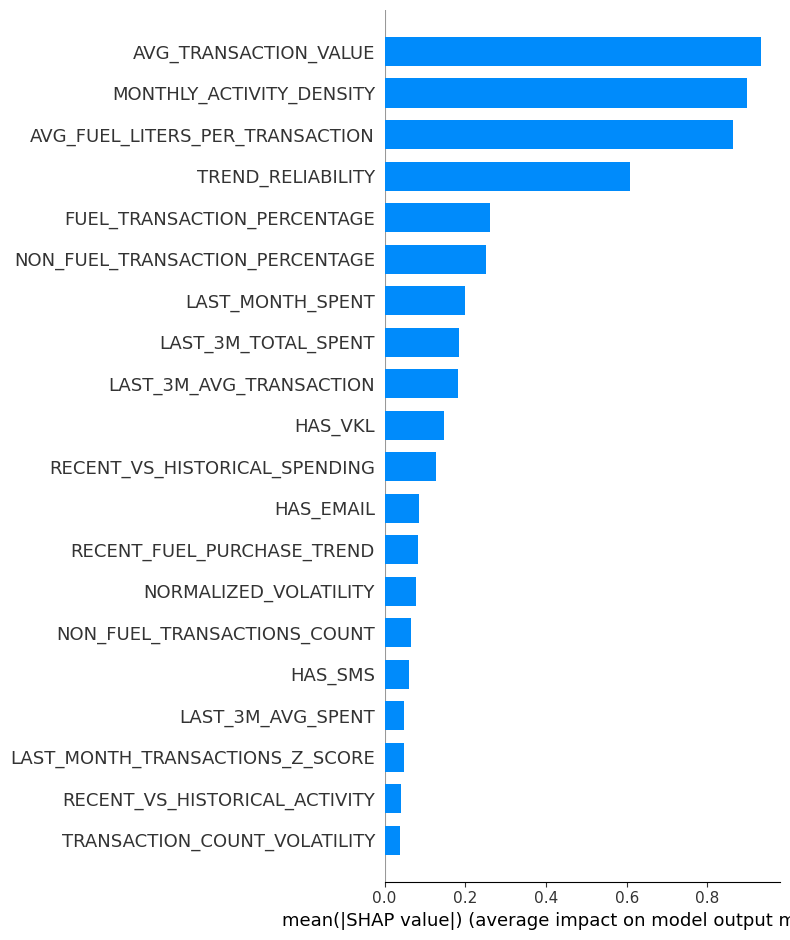

In [198]:
import shap

# Создаём объект explainer для модели XGBoost
explainer = shap.TreeExplainer(bst)
# Рассчитываем SHAP значения для тестовой выборки
shap_values = explainer.shap_values(dtest)

# Визуализация: классическая диаграмма summary_plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


C:\Users\kostinkd\AppData\Local\Temp\ipykernel_24540\1082790258.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


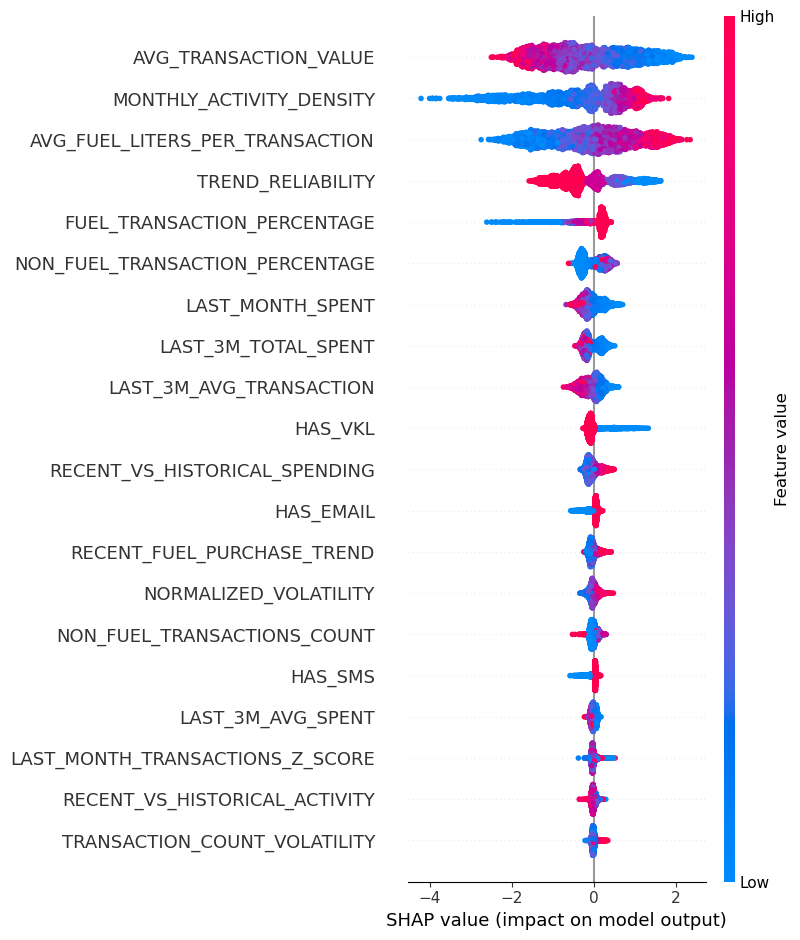


Топ-10 признаков, влияющих на отток:
                            Feature  Importance
3             AVG_TRANSACTION_VALUE    0.933131
19         MONTHLY_ACTIVITY_DENSITY    0.897813
35  AVG_FUEL_LITERS_PER_TRANSACTION    0.862832
27                TREND_RELIABILITY    0.608512
33      FUEL_TRANSACTION_PERCENTAGE    0.260947
34  NON_FUEL_TRANSACTION_PERCENTAGE    0.250309
8                  LAST_MONTH_SPENT    0.200191
11              LAST_3M_TOTAL_SPENT    0.184919
12          LAST_3M_AVG_TRANSACTION    0.181920
2                           HAS_VKL    0.146726


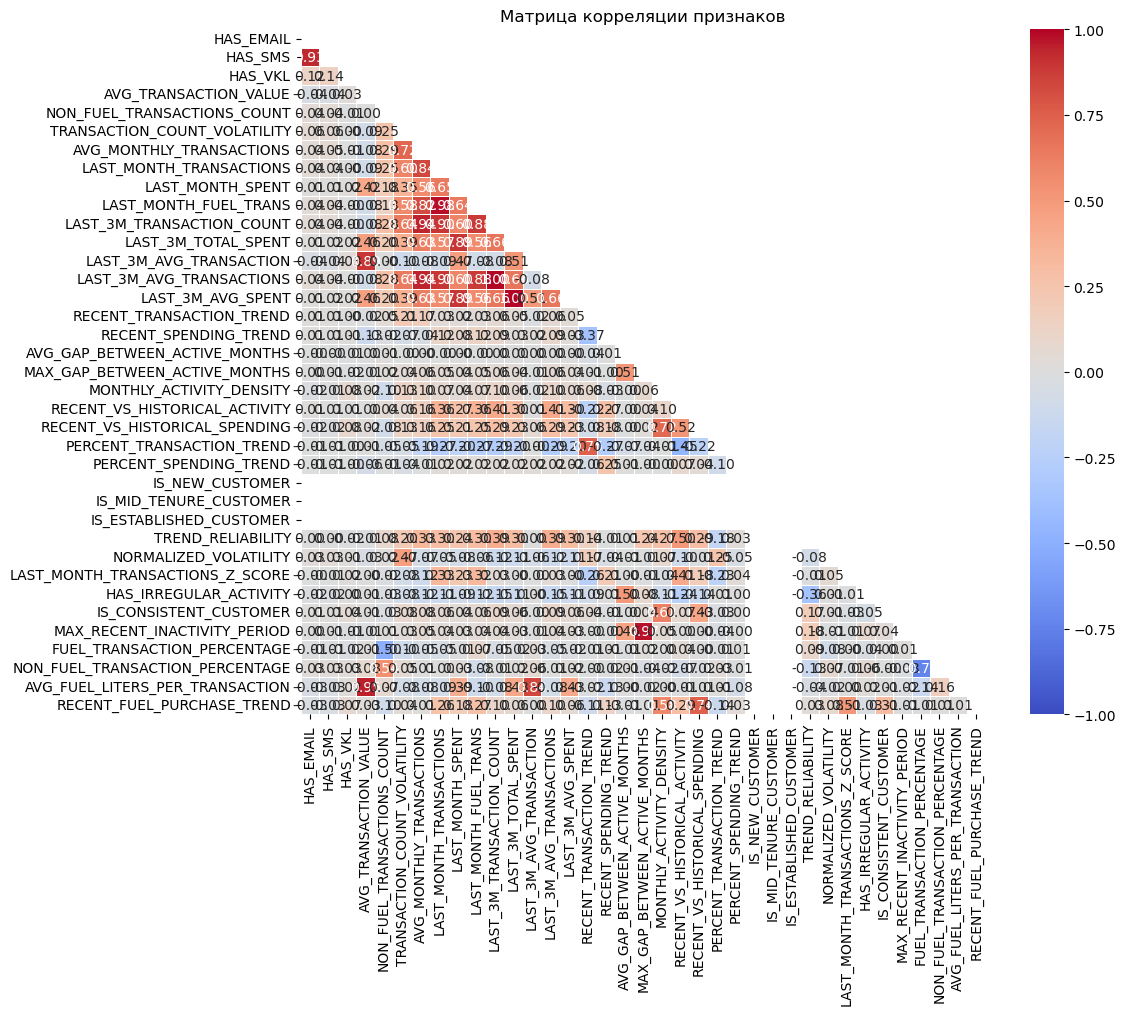

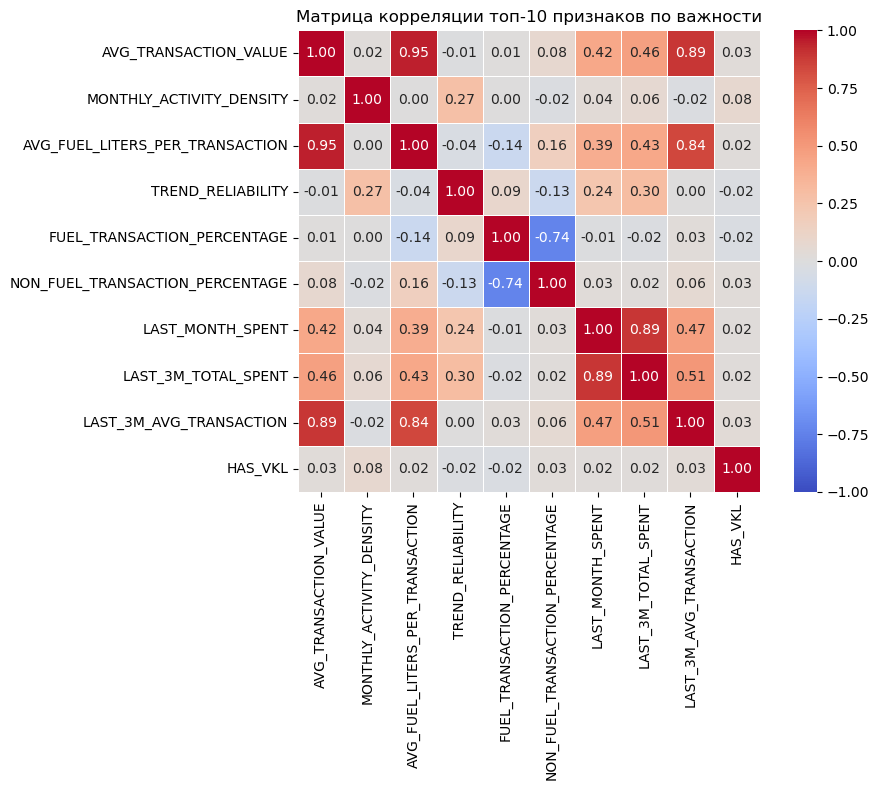

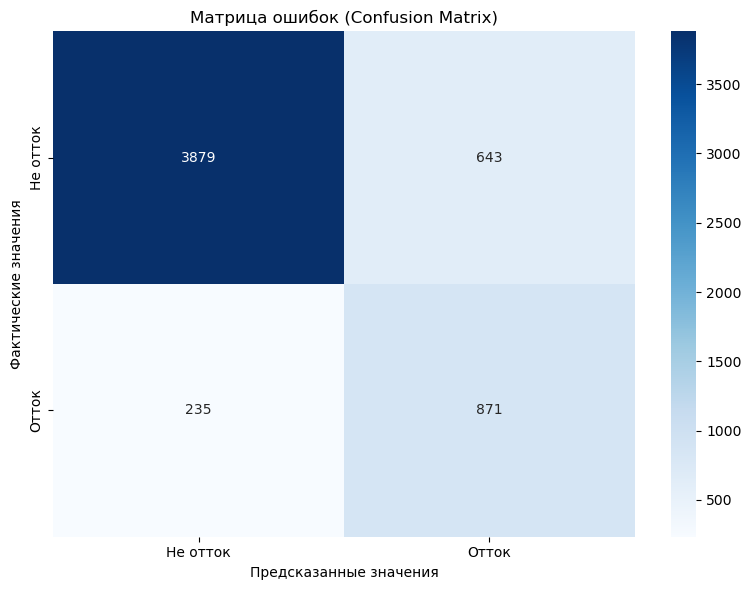


Отчет о классификации:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      4522
           1       0.58      0.79      0.66      1106

    accuracy                           0.84      5628
   macro avg       0.76      0.82      0.78      5628
weighted avg       0.87      0.84      0.85      5628

Точность модели (Accuracy): 0.8440


In [199]:
# SHAP summary plot for individual observations
shap.summary_plot(shap_values, X_test)

# Compute feature importance based on SHAP values
feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Display top 10 features influencing churn
print("\nTop 10 features influencing churn:")
print(feature_importance.head(10))

# Plot feature correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = X_train.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    mask=mask,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=.5
)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Correlation matrix for top features by importance
top_features = feature_importance['Feature'].head(10).tolist()
plt.figure(figsize=(10, 8))
top_corr = X_train[top_features].corr()
sns.heatmap(
    top_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=.5
)
plt.title('Correlation Matrix of Top 10 Features by Importance')
plt.tight_layout()
plt.show()

# Plot confusion matrix
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test['CHURN'], y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['No Churn', 'Churn'],
    yticklabels=['No Churn', 'Churn']
)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test['CHURN'], y_pred_binary))

# Calculate and print accuracy
accuracy = accuracy_score(y_test['CHURN'], y_pred_binary)
print(f"Model Accuracy: {accuracy:.4f}")


# Optimizing XGBoost: GA Tuning, Adaptive Threshold, and SHAP Interpretation

Class distribution:
shape: (2, 1)
┌───────────┐
│ CHURN     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {0,22607} │
│ {1,5529}  │
└───────────┘
Scale pos weight: 4.088853719195116


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

gen	nevals
0  	30    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:46:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

1  	15    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

2  	15    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

3  	16    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

4  	19    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

5  	15    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

6  	21    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

7  	20    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

8  	18    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

9  	15    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

10 	13    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

11 	20    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

12 	17    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

13 	20    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:57:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

14 	19    


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:58:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\ko

15 	17    
Best hyperparameters found by GA: [5.0, 0.15620531118115327, 1.9297634787245725, 0.8079293180130659, 0.9470330105820934]
Attempting to use CUDA for training...


c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.81003+0.00213	test-auc:0.79776+0.00261
[1]	train-auc:0.82342+0.00319	test-auc:0.80940+0.00180
[2]	train-auc:0.83164+0.00209	test-auc:0.81567+0.00434
[3]	train-auc:0.83619+0.00213	test-auc:0.81928+0.00493
[4]	train-auc:0.83997+0.00199	test-auc:0.82169+0.00443
[5]	train-auc:0.84447+0.00206	test-auc:0.82463+0.00336
[6]	train-auc:0.84716+0.00188	test-auc:0.82594+0.00289
[7]	train-auc:0.85013+0.00155	test-auc:0.82752+0.00335
[8]	train-auc:0.85344+0.00146	test-auc:0.83018+0.00373
[9]	train-auc:0.85628+0.00123	test-auc:0.83278+0.00363
[10]	train-auc:0.85858+0.00125	test-auc:0.83416+0.00425
[11]	train-auc:0.86033+0.00151	test-auc:0.83466+0.00462
[12]	train-auc:0.86406+0.00328	test-auc:0.83821+0.00785
[13]	train-auc:0.86746+0.00353	test-auc:0.84078+0.00795
[14]	train-auc:0.87164+0.00253	test-auc:0.84436+0.00785
[15]	train-auc:0.87606+0.00237	test-auc:0.84803+0.00593
[16]	train-auc:0.87793+0.00182	test-auc:0.84934+0.00488
[17]	train-auc:0.88189+0.00390	test-auc:0.85232+0.00559
[1

c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\kostinkd\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:59:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[9]	train-auc:0.85134	eval-auc:0.84062
[10]	train-auc:0.85290	eval-auc:0.84244
[11]	train-auc:0.85480	eval-auc:0.84276
[12]	train-auc:0.85877	eval-auc:0.84605
[13]	train-auc:0.86053	eval-auc:0.84765
[14]	train-auc:0.86495	eval-auc:0.85188
[15]	train-auc:0.87324	eval-auc:0.85931
[16]	train-auc:0.87450	eval-auc:0.85968
[17]	train-auc:0.87630	eval-auc:0.86057
[18]	train-auc:0.87754	eval-auc:0.86020
[19]	train-auc:0.88172	eval-auc:0.86300
[20]	train-auc:0.88323	eval-auc:0.86336
[21]	train-auc:0.88411	eval-auc:0.86264
[22]	train-auc:0.88852	eval-auc:0.86639
[23]	train-auc:0.88987	eval-auc:0.86636
[24]	train-auc:0.89171	eval-auc:0.86746
[25]	train-auc:0.89353	eval-auc:0.86816
[26]	train-auc:0.89520	eval-auc:0.86848
[27]	train-auc:0.89991	eval-auc:0.87303
[28]	train-auc:0.90134	eval-auc:0.87413
[29]	train-auc:0.90464	eval-auc:0.87728
[30]	train-auc:0.90956	eval-auc:0.88165
[31]	train-auc:0.91173	eval-auc:0.88318
[32]	train-auc:0.91326	eval-auc:0.88388
[33]	train-auc:0.91721	eval-auc:0.88721
[

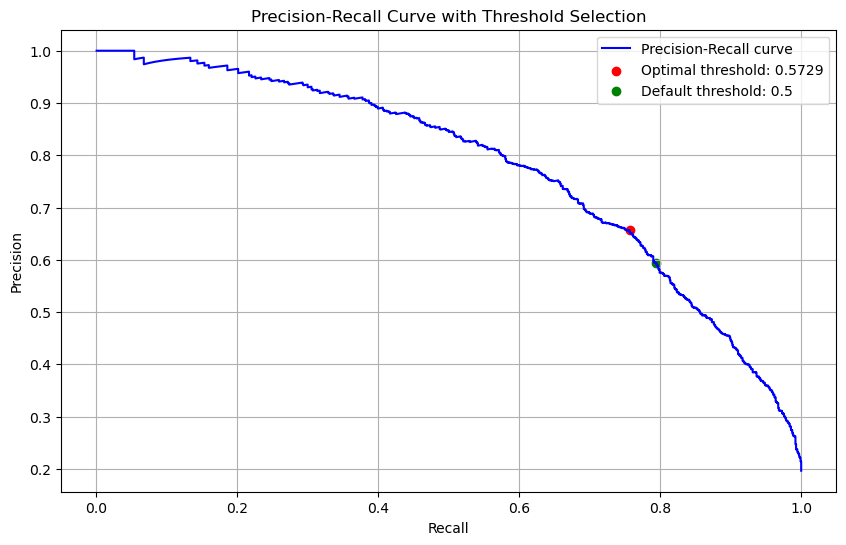

C:\Users\kostinkd\AppData\Local\Temp\ipykernel_24540\817966631.py:271: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


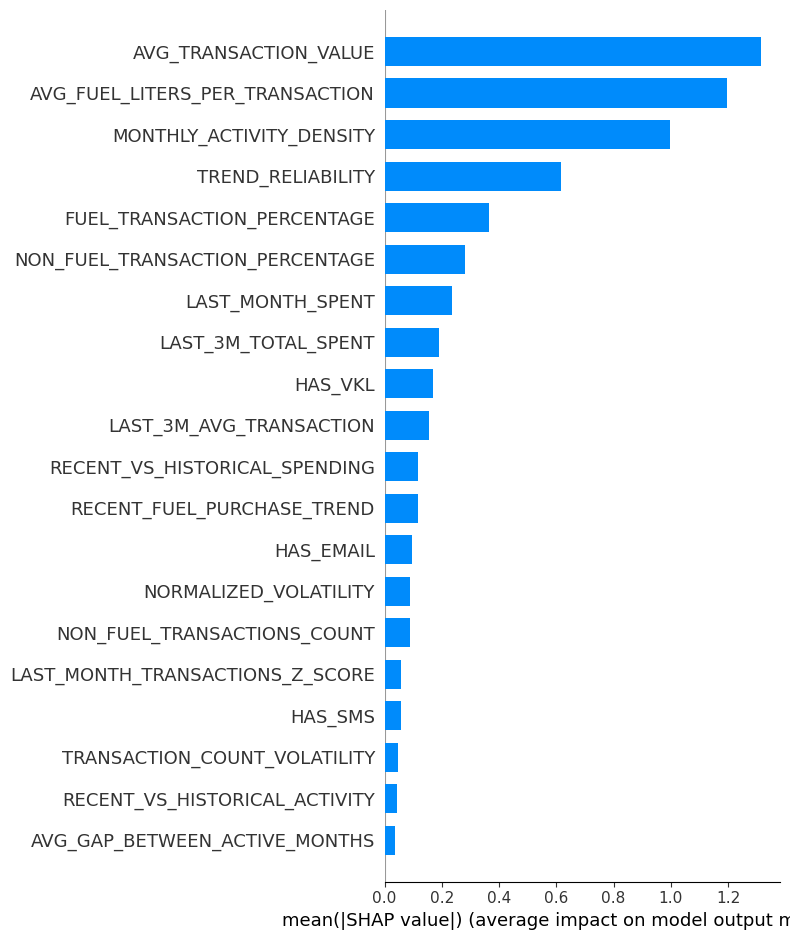

C:\Users\kostinkd\AppData\Local\Temp\ipykernel_24540\817966631.py:272: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


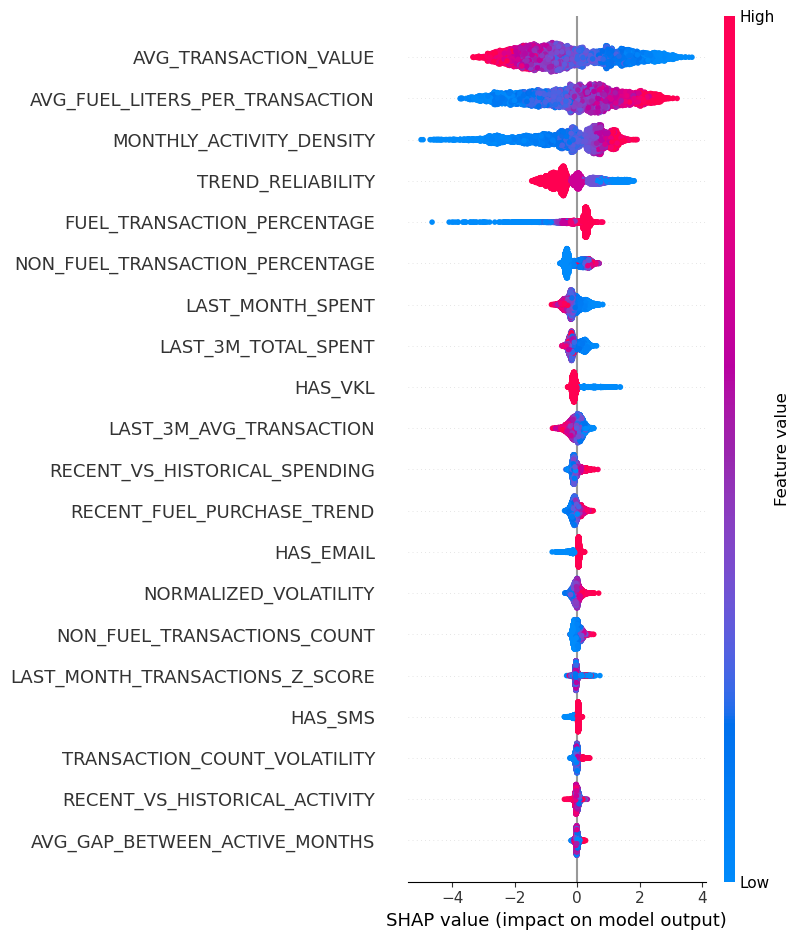


Top 10 features influencing churn:
                            Feature  Importance
3             AVG_TRANSACTION_VALUE    1.315257
35  AVG_FUEL_LITERS_PER_TRANSACTION    1.197432
19         MONTHLY_ACTIVITY_DENSITY    0.995745
27                TREND_RELIABILITY    0.615342
33      FUEL_TRANSACTION_PERCENTAGE    0.365487
34  NON_FUEL_TRANSACTION_PERCENTAGE    0.280225
8                  LAST_MONTH_SPENT    0.235010
11              LAST_3M_TOTAL_SPENT    0.191414
2                           HAS_VKL    0.167862
12          LAST_3M_AVG_TRANSACTION    0.156619


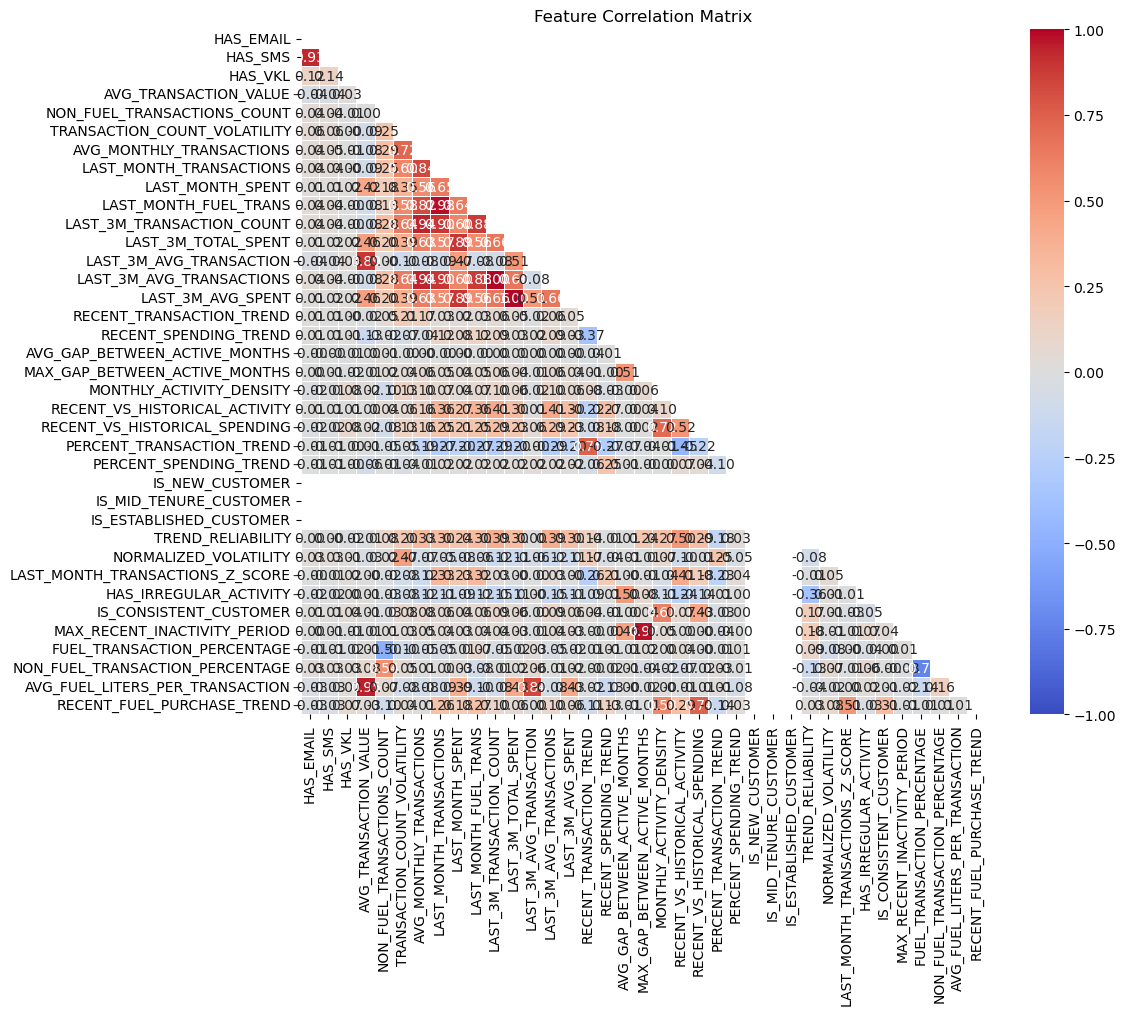

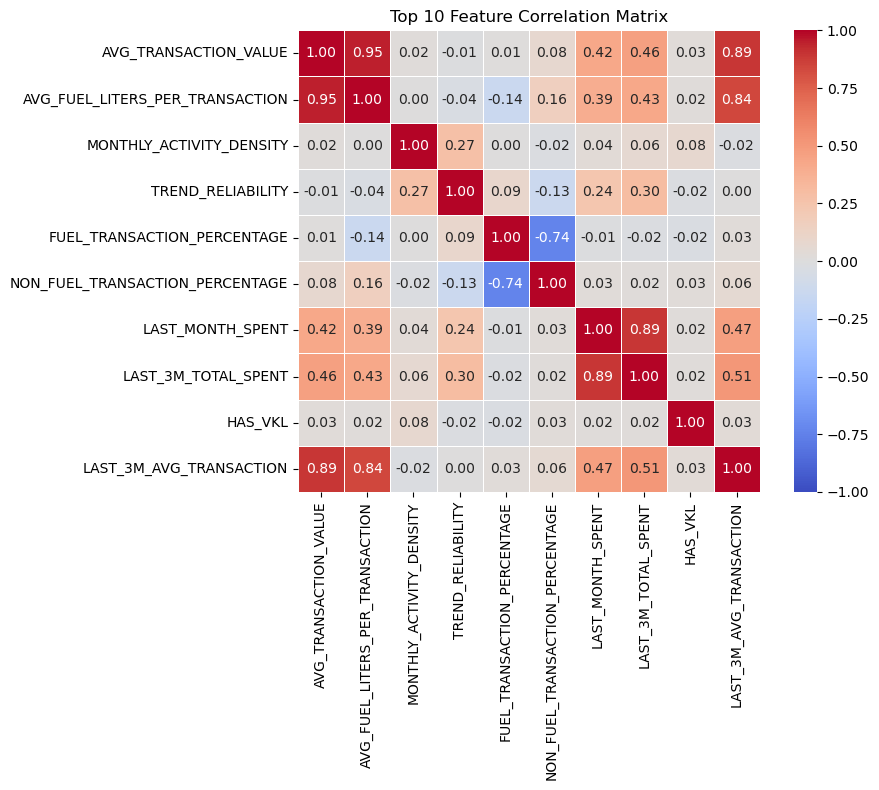

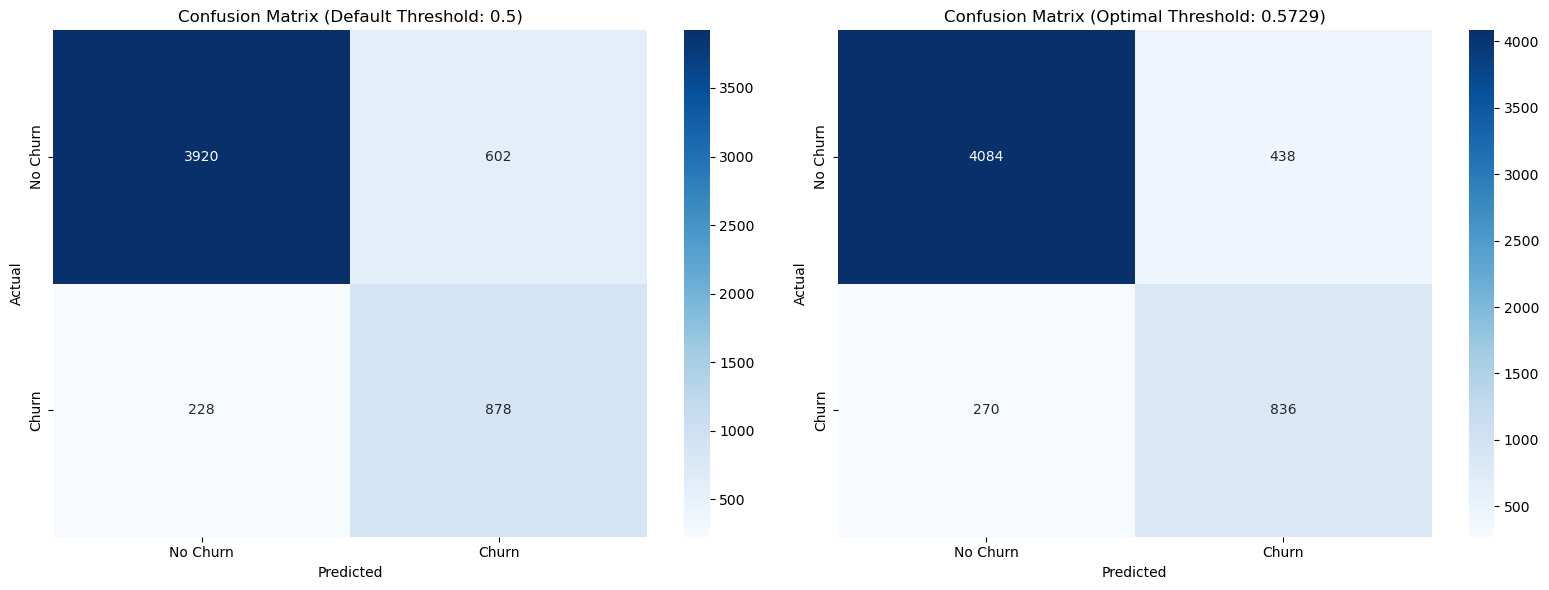


Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

           0       0.95      0.87      0.90      4522
           1       0.59      0.79      0.68      1106

    accuracy                           0.85      5628
   macro avg       0.77      0.83      0.79      5628
weighted avg       0.88      0.85      0.86      5628


Classification Report (Optimal Threshold 0.5729):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      4522
           1       0.66      0.76      0.70      1106

    accuracy                           0.87      5628
   macro avg       0.80      0.83      0.81      5628
weighted avg       0.88      0.87      0.88      5628

Model Accuracy (Default Threshold): 0.8525
Model Accuracy (Optimal Threshold): 0.8742

Business Impact Analysis:
Using the optimal threshold of 0.5729 instead of the default 0.5:
• 42 more missed churners
• 164 fewer false churn predictions

Recom

In [200]:
# For Genetic Algorithm (GA) hyperparameter tuning using DEAP
from deap import base, creator, tools, algorithms

# Select features and target variable
X = churn_features_df.select([col for col in churn_features_df.columns if col not in [
    "CHURN", "CLIENT_ID_SAP", "HAS_RECENT_INACTIVITY", "LATEST_TRANSACTION_DATE", "LAST_ACTIVE_MONTH", "MONTHS_SINCE_LAST_ACTIVITY",
    "ACTIVE_MONTHS", "MONTHS_AT_LEVEL", "CUSTOMER_TENURE_DAYS", "TOTAL_SPENT",
    "TOTAL_FUEL_LITERS", "TOTAL_TRANSACTIONS", "FUEL_TRANSACTIONS_COUNT", "LAST_TRANSACTION_DATE", "FIRST_ACTIVE_MONTH", "FIRST_TRANSACTION_DATE"
]])
y = churn_features_df.select("CHURN")

# Check class distribution
class_counts = y.select(pl.col("CHURN").value_counts()).sort("CHURN")
print("Class distribution:")
print(class_counts)

if len(class_counts) < 2:
    print("Error: Only one class present in the dataset. Cannot proceed with binary classification.")
else:
    # Split data into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X.to_pandas(),
        y.to_pandas(),
        test_size=0.2,
        random_state=42,
        stratify=y.to_pandas()
    )
    
    # Calculate scale_pos_weight to address class imbalance
    pos_weight = float((y_train['CHURN'] == 0).sum() / (y_train['CHURN'] == 1).sum())
    print(f"Scale pos weight: {pos_weight}")
    
    # Genetic Algorithm for Hyperparameter Tuning (GA-XGBoost)
    # Define evaluation function for GA: we use 3-fold CV on a small number of rounds for speed.
    def eval_xgb(individual):
        # Unpack hyperparameters: max_depth, eta, min_child_weight, subsample, colsample_bytree
        max_depth, eta, min_child_weight, subsample, colsample_bytree = individual
        
        # Clip hyperparameters to their bounds
        eta = max(min(eta, 0.3), 0.01)
        min_child_weight = max(min(min_child_weight, 10), 1)
        subsample = max(min(subsample, 1.0), 0.5)
        colsample_bytree = max(min(colsample_bytree, 1.0), 0.5)
        
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': int(max_depth),
            'eta': eta,
            'min_child_weight': min_child_weight,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'seed': 42,
            'scale_pos_weight': pos_weight,
            'tree_method': 'hist',
            'device': 'cuda',  # Try to use CUDA
        }
        
        try:
            cv_results = xgb.cv(
                params=params,
                dtrain=xgb.DMatrix(X_train, label=y_train['CHURN']),
                num_boost_round=100,  # fewer rounds for faster evaluation
                nfold=3,
                stratified=True,
                early_stopping_rounds=5,
                metrics='auc',
                seed=42,
                verbose_eval=False
            )
            best_auc = cv_results['test-auc-mean'].max()
        except Exception as e:
            print(f"Error during XGBoost CV: {e}")
            # Fallback to CPU if CUDA fails
            params['device'] = 'cpu'
            cv_results = xgb.cv(
                params=params,
                dtrain=xgb.DMatrix(X_train, label=y_train['CHURN']),
                num_boost_round=100,
                nfold=3,
                stratified=True,
                early_stopping_rounds=5,
                metrics='auc',
                seed=42,
                verbose_eval=False
            )
            best_auc = cv_results['test-auc-mean'].max()
            
        # DEAP minimizes fitness; return negative AUC so that higher AUC yields lower fitness.
        return -best_auc,
    
    # Check if DEAP classes already exist and delete them if they do
    if 'FitnessMin' in dir(creator):
        del creator.FitnessMin
    if 'Individual' in dir(creator):
        del creator.Individual
    
    # Set up DEAP for GA optimization
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    # Define attribute generators for hyperparameters:
    toolbox.register("max_depth", random.randint, 3, 10)
    toolbox.register("eta", random.uniform, 0.01, 0.3)
    toolbox.register("min_child_weight", random.uniform, 1, 10)
    toolbox.register("subsample", random.uniform, 0.5, 1.0)
    toolbox.register("colsample_bytree", random.uniform, 0.5, 1.0)
    
    # Create individuals and population
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.max_depth, toolbox.eta, toolbox.min_child_weight,
                      toolbox.subsample, toolbox.colsample_bytree), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("evaluate", eval_xgb)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    random.seed(42)
    population = toolbox.population(n=30)
    ngen = 15
    cxpb = 0.5
    mutpb = 0.2

    
    # Run GA optimization
    hof = tools.HallOfFame(1)
    algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, halloffame=hof, verbose=True)
    
    best_params = hof[0]
    print("Best hyperparameters found by GA:", best_params)
    
    # Set final parameters using the best GA results (apply clipping as before)
    final_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': int(best_params[0]),
        'eta': max(min(best_params[1], 0.3), 0.01),
        'min_child_weight': max(min(best_params[2], 10), 1),
        'subsample': max(min(best_params[3], 1.0), 0.5),
        'colsample_bytree': max(min(best_params[4], 1.0), 0.5),
        'seed': 42,
        'scale_pos_weight': pos_weight,
        'tree_method': 'hist',
        'device': 'cuda',  # Try to use CUDA
        'n_jobs': -1       # Use all CPU cores for operations that can be parallelized
    }
    
    # Cross-Validation with Optimized Hyperparameters
    # Try to use CUDA, fallback to CPU if it fails
    try:
        print("Attempting to use CUDA for training...")
        cv_results = xgb.cv(
            params=final_params,
            dtrain=xgb.DMatrix(X_train, label=y_train['CHURN']),
            num_boost_round=200,
            nfold=5,
            stratified=True,
            early_stopping_rounds=10,
            metrics='auc',
            seed=42,
            verbose_eval=True
        )
    except Exception as e:
        print(f"CUDA training failed with error: {e}")
        print("Falling back to CPU training...")
        final_params['device'] = 'cpu'
        cv_results = xgb.cv(
            params=final_params,
            dtrain=xgb.DMatrix(X_train, label=y_train['CHURN']),
            num_boost_round=200,
            nfold=5,
            stratified=True,
            early_stopping_rounds=10,
            metrics='auc',
            seed=42,
            verbose_eval=True
        )
    
    best_num_rounds = cv_results.shape[0]
    print(f"Best number of rounds from CV: {best_num_rounds}")
    
    # Train final XGBoost model with optimized hyperparameters
    dtrain = xgb.DMatrix(X_train, label=y_train['CHURN'])
    dtest = xgb.DMatrix(X_test, label=y_test['CHURN'])
    
    try:
        bst = xgb.train(
            final_params,
            dtrain,
            num_boost_round=best_num_rounds,
            evals=[(dtrain, 'train'), (dtest, 'eval')],
            early_stopping_rounds=10,
            verbose_eval=True
        )
    except Exception as e:
        print(f"Error during final model training: {e}")
        final_params['device'] = 'cpu' # Fallback to CPU if CUDA training fails
        bst = xgb.train(
            final_params,
            dtrain,
            num_boost_round=best_num_rounds,
            evals=[(dtrain, 'train'), (dtest, 'eval')],
            early_stopping_rounds=10,
            verbose_eval=True
        )
    
    # Print the device being used for training
    print(f"Training completed using device: {final_params['device']}")
    
    # Model Evaluation and SHAP Interpretability
    y_pred = bst.predict(dtest)
    auc_value = roc_auc_score(y_test['CHURN'], y_pred)
    print(f"\nFinal AUC: {auc_value:.4f}")
    
    # Calculate and apply optimal threshold based on F1-score
    from sklearn.metrics import precision_recall_curve, f1_score

    # Find the optimal threshold
    precision, recall, thresholds = precision_recall_curve(y_test['CHURN'], y_pred)
    # Add a small epsilon to avoid division by zero if precision and recall are both zero
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10) 
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold: {optimal_threshold:.4f}")

    # Create predictions with both default (0.5) and optimal thresholds for comparison
    y_pred_default = (y_pred > 0.5).astype(int)
    y_pred_optimal = (y_pred > optimal_threshold).astype(int)
    
    # Plot precision-recall curve to visualize the threshold choice
    plt.figure(figsize=(10, 6))
    plt.plot(recall[:-1], precision[:-1], 'b-', label='Precision-Recall curve')
    plt.scatter(recall[optimal_idx], precision[optimal_idx], marker='o', color='red', 
                label=f'Optimal threshold: {optimal_threshold:.4f}')
    # Find point closest to 0.5 threshold for plotting
    default_threshold_idx = np.abs(thresholds - 0.5).argmin()
    plt.scatter(recall[default_threshold_idx], precision[default_threshold_idx], 
                marker='o', color='green', label='Default threshold: 0.5')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve with Threshold Selection')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # SHAP analysis for global and local interpretability
    explainer = shap.TreeExplainer(bst)
    shap_values = explainer.shap_values(dtest) # SHAP values for the test set
    
    # Classic SHAP summary plots (bar and beeswarm)
    shap.summary_plot(shap_values, X_test, plot_type="bar") # Bar plot of mean absolute SHAP values
    shap.summary_plot(shap_values, X_test) # Beeswarm plot for detailed feature impact
    
    # Calculate feature importance from SHAP values
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': np.abs(shap_values).mean(0) # Mean absolute SHAP value per feature
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 features influencing churn (based on SHAP values):")
    print(feature_importance.head(10))
    
    # Correlation matrix for all features in the training set
    plt.figure(figsize=(12, 10))
    correlation_matrix = pd.DataFrame(X_train).corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) # Mask for upper triangle
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                mask=mask, vmin=-1, vmax=1, square=True, linewidths=.5)
    plt.title('Feature Correlation Matrix (All Features)')
    plt.tight_layout()
    plt.show()
    
    # Correlation matrix for top 10 features (identified by SHAP)
    top_features = feature_importance['Feature'].head(10).tolist()
    plt.figure(figsize=(10, 8))
    top_corr = pd.DataFrame(X_train)[top_features].corr()
    sns.heatmap(top_corr, annot=True, fmt=".2f", cmap='coolwarm',
                vmin=-1, vmax=1, square=True, linewidths=.5)
    plt.title('Top 10 Feature Correlation Matrix (SHAP based)')
    plt.tight_layout()
    plt.show()

    # Compare confusion matrices: Default vs Optimal threshold
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Default threshold confusion matrix
    conf_matrix_default = confusion_matrix(y_test['CHURN'], y_pred_default)
    sns.heatmap(conf_matrix_default, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'], ax=ax1)
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title('Confusion Matrix (Default Threshold: 0.5)')
    
    # Optimal threshold confusion matrix
    conf_matrix_optimal = confusion_matrix(y_test['CHURN'], y_pred_optimal)
    sns.heatmap(conf_matrix_optimal, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'], ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    ax2.set_title(f'Confusion Matrix (Optimal Threshold: {optimal_threshold:.4f})')
    
    plt.tight_layout()
    plt.show()

    # Classification reports for both thresholds
    print("\nClassification Report (Default Threshold 0.5):")
    print(classification_report(y_test['CHURN'], y_pred_default))
    
    print(f"\nClassification Report (Optimal Threshold {optimal_threshold:.4f}):")
    print(classification_report(y_test['CHURN'], y_pred_optimal))
    
    # Calculate accuracy for both thresholds
    accuracy_default = accuracy_score(y_test['CHURN'], y_pred_default)
    accuracy_optimal = accuracy_score(y_test['CHURN'], y_pred_optimal)
    
    print(f"Model Accuracy (Default Threshold): {accuracy_default:.4f}")
    print(f"Model Accuracy (Optimal Threshold): {accuracy_optimal:.4f}")
    
    # Business impact comparison if optimal threshold is different from 0.5
    # This section analyzes the trade-offs in terms of false positives and false negatives.
    if optimal_threshold > 0.5: # Example condition, can be adjusted based on specific needs
        print("\nBusiness Impact Analysis:")
        print(f"Using the optimal threshold of {optimal_threshold:.4f} instead of the default 0.5:")
        
        # Calculate the differences in predictions
        fn_default = conf_matrix_default[1][0]  # False negatives with default threshold
        fn_optimal = conf_matrix_optimal[1][0]  # False negatives with optimal threshold
        fp_default = conf_matrix_default[0][1]  # False positives with default threshold
        fp_optimal = conf_matrix_optimal[0][1]  # False positives with optimal threshold
        
        # Compare false negatives (missed churners)
        fn_diff = fn_default - fn_optimal
        print(f"• {abs(fn_diff)} {'fewer' if fn_diff > 0 else 'more'} missed churners (False Negatives)")
        
        # Compare false positives (false alarms)
        fp_diff = fp_default - fp_optimal
        print(f"• {abs(fp_diff)} {'fewer' if fp_diff > 0 else 'more'} false churn predictions (False Positives)")
        
        # Business recommendation based on changes
        print("\nRecommendation:")
        if fn_diff > 0 and fp_diff < 0:
            print("The optimal threshold trades some false positives for better detection of actual churners.")
            print("This is beneficial when the cost of missing a churner is higher than the cost of a retention action.")
        elif fn_diff < 0 and fp_diff > 0:
            print("The optimal threshold reduces false positives at the expense of missing more churners.")
            print("This is beneficial when retention actions are costly and should be more precisely targeted.")
        else:
            print("The optimal threshold improves both precision and recall, providing better overall performance.")


# XGBoost: Hyperparameter Optimization with GA, SHAP Feature Importance, and Optimal Threshold Selection

Class distribution:
shape: (2, 1)
┌───────────┐
│ CHURN     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {0,22607} │
│ {1,5529}  │
└───────────┘
Scale pos weight: 4.088853719195116

=== MODEL VARIANT 1: Baseline XGBoost with Optimal Threshold ===
Starting genetic algorithm optimization...
gen	nevals	avg      	min      	max      
0  	30    	-0.883816	-0.905425	-0.824347
1  	14    	-0.895651	-0.906771	-0.831723
2  	12    	-0.900404	-0.906771	-0.855432
3  	20    	-0.903287	-0.90777 	-0.877467
4  	11    	-0.905582	-0.908829	-0.899185
5  	20    	-0.90676 	-0.909346	-0.894705
6  	20    	-0.906614	-0.910112	-0.882508
7  	17    	-0.907886	-0.910112	-0.902497
8  	17    	-0.908337	-0.910112	-0.905106
9  	10    	-0.908736	-0.910112	-0.90676 
10 	19    	-0.908576	-0.910112	-0.90606 
11 	23    	-0.908632	-0.910112	-0.904   
12 	21    	-0.909102	-0.910112	-0.904988
13 	18    	-0.909402	-0.910112	-0.904204
14 	20    	-0.909585	-0.910112	-0.904143
15 	23    	-0.90935 	-0.910112	-0.903723
Best hyperpa

C:\Users\kostinkd\AppData\Local\Temp\ipykernel_24540\3172761271.py:210: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


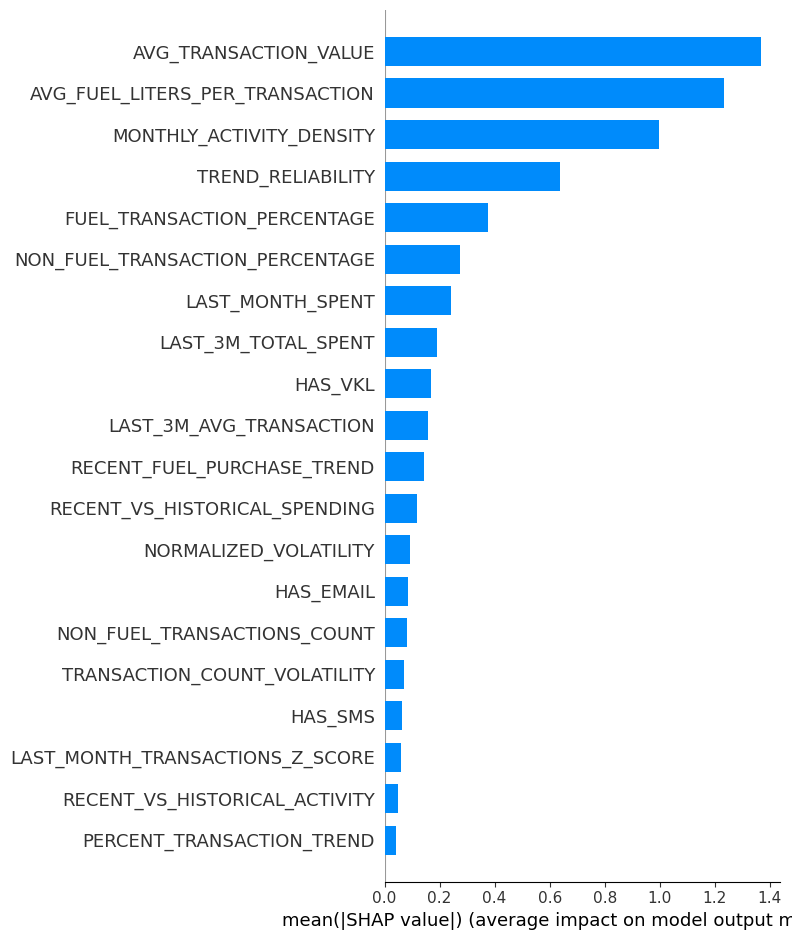

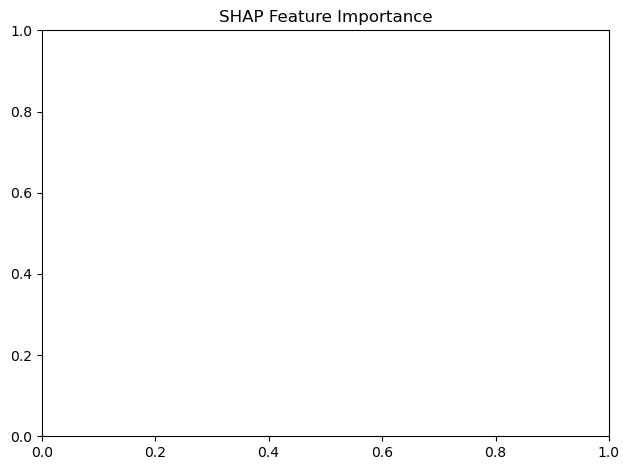

Optimal threshold: 0.6200
Baseline model accuracy (optimal threshold): 0.8822
Baseline classification report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4522
           1       0.70      0.71      0.70      1106

    accuracy                           0.88      5628
   macro avg       0.81      0.82      0.82      5628
weighted avg       0.88      0.88      0.88      5628



In [203]:
# Select features and target variable
X = churn_features_df.select([col for col in churn_features_df.columns if col not in [
    "CHURN", "CLIENT_ID_SAP", "HAS_RECENT_INACTIVITY", "LATEST_TRANSACTION_DATE", "LAST_ACTIVE_MONTH", "MONTHS_SINCE_LAST_ACTIVITY",
    "ACTIVE_MONTHS", "MONTHS_AT_LEVEL", "CUSTOMER_TENURE_DAYS", "TOTAL_SPENT",
    "TOTAL_FUEL_LITERS", "TOTAL_TRANSACTIONS", "FUEL_TRANSACTIONS_COUNT", "LAST_TRANSACTION_DATE", "FIRST_ACTIVE_MONTH", "FIRST_TRANSACTION_DATE"
]])
y = churn_features_df.select("CHURN")

# Check class distribution
class_counts = y.select(pl.col("CHURN").value_counts()).sort("CHURN")
print("Class distribution:")
print(class_counts)

if len(class_counts) < 2:
    print("Error: Only one class present in the dataset. Cannot proceed with binary classification.")
else:
    # Split data into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X.to_pandas(),
        y.to_pandas(),
        test_size=0.2,
        random_state=42,
        stratify=y.to_pandas()
    )
    
    # Calculate scale_pos_weight to address class imbalance
    pos_weight = float((y_train['CHURN'] == 0).sum() / (y_train['CHURN'] == 1).sum())
    print(f"Scale pos weight: {pos_weight}")
    
    print("\n=== MODEL VARIANT 1: Baseline XGBoost with Optimal Threshold ===")
    
    # Define evaluation function for Genetic Algorithm (GA)
    def eval_xgb(individual):
        # Unpack hyperparameters: max_depth, eta, min_child_weight, subsample, colsample_bytree, alpha, lambda
        max_depth, eta, min_child_weight, subsample, colsample_bytree, alpha, lambda_param = individual
        
        # Clip hyperparameters to their valid bounds
        eta = max(min(eta, 0.3), 0.01)
        min_child_weight = max(min(min_child_weight, 10), 1)
        subsample = max(min(subsample, 1.0), 0.5)
        colsample_bytree = max(min(colsample_bytree, 1.0), 0.5)
        alpha = max(min(alpha, 10), 0)
        lambda_param = max(min(lambda_param, 10), 0)
        
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': int(max_depth),
            'eta': eta,
            'min_child_weight': min_child_weight,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'alpha': alpha,
            'lambda': lambda_param,
            'seed': 42,
            'scale_pos_weight': pos_weight
        }
        
        try:
            # Perform cross-validation
            cv_results = xgb.cv(
                params=params,
                dtrain=xgb.DMatrix(X_train, label=y_train['CHURN']),
                num_boost_round=100,
                nfold=3,
                stratified=True,
                early_stopping_rounds=5,
                metrics='auc',
                seed=42,
                verbose_eval=False
            )
            best_auc = cv_results['test-auc-mean'].max()
        except Exception as e:
            print(f"CV error: {e}")
            best_auc = 0.5 # Default to a neutral AUC if an error occurs
            
        return -best_auc, # Minimize negative AUC (equivalent to maximizing AUC)
    
    # Set up DEAP for Genetic Algorithm (GA) optimization
    # Ensure FitnessMin and Individual are not already defined to avoid warnings
    if 'FitnessMin' in dir(creator):
        del creator.FitnessMin
        del creator.Individual
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Objective: minimize (negative AUC)
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    # Define attribute (hyperparameter) generators for GA
    toolbox.register("max_depth", random.randint, 3, 10)
    toolbox.register("eta", random.uniform, 0.01, 0.3) # Learning rate
    toolbox.register("min_child_weight", random.uniform, 1, 10)
    toolbox.register("subsample", random.uniform, 0.5, 1.0) # Subsample ratio of the training instance
    toolbox.register("colsample_bytree", random.uniform, 0.5, 1.0) # Subsample ratio of columns when constructing each tree
    toolbox.register("alpha", random.uniform, 0, 10)  # L1 regularization term on weights
    toolbox.register("lambda_param", random.uniform, 0, 10)  # L2 regularization term on weights
    
    # Create GA individuals (sets of hyperparameters) and population
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.max_depth, toolbox.eta, toolbox.min_child_weight,
                      toolbox.subsample, toolbox.colsample_bytree, 
                      toolbox.alpha, toolbox.lambda_param), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    # Register genetic operators
    toolbox.register("evaluate", eval_xgb) # Evaluation function
    toolbox.register("mate", tools.cxBlend, alpha=0.5) # Crossover operator
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2) # Mutation operator
    toolbox.register("select", tools.selTournament, tournsize=3) # Selection operator
    
    # Configure statistics to track GA optimization progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # Set GA parameters
    random.seed(42) # For reproducibility
    population = toolbox.population(n=30) # Population size
    ngen = 15 # Number of generations
    cxpb = 0.5 # Crossover probability
    mutpb = 0.2 # Mutation probability
    
    # Run Genetic Algorithm optimization
    print("Starting genetic algorithm optimization...")
    hof = tools.HallOfFame(1) # Store the best individual
    algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=hof, verbose=True)
    
    best_params_ga = hof[0] 
    print("Best hyperparameters found by GA:", best_params_ga)
    
    # Set final XGBoost parameters using the best GA results
    # Ensure hyperparameters are within valid ranges after GA optimization
    final_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': int(best_params_ga[0]),
        'eta': max(min(best_params_ga[1], 0.3), 0.01),
        'min_child_weight': max(min(best_params_ga[2], 10), 1),
        'subsample': max(min(best_params_ga[3], 1.0), 0.5),
        'colsample_bytree': max(min(best_params_ga[4], 1.0), 0.5),
        'alpha': max(min(best_params_ga[5], 10), 0),
        'lambda': max(min(best_params_ga[6], 10), 0),
        'seed': 42,
        'scale_pos_weight': pos_weight
    }
    
    print("Final hyperparameters for Model Variant 1:")
    for key, value in final_params.items():
        print(f"{key}: {value}")
    
    # Cross-Validation with GA-optimized hyperparameters to find best num_boost_round
    dtrain = xgb.DMatrix(X_train, label=y_train['CHURN'])
    cv_results = xgb.cv(
        params=final_params,
        dtrain=dtrain,
        num_boost_round=200, # Max number of rounds
        nfold=5, # Number of CV folds
        stratified=True, # Stratified sampling for CV
        early_stopping_rounds=10, # Stop if no improvement after 10 rounds
        metrics=['auc', 'error'], # Evaluation metrics
        seed=42,
        verbose_eval=True
    )
    best_num_rounds = cv_results.shape[0] # Number of rounds that gave the best AUC
    print(f"Best number of rounds from CV for Model Variant 1: {best_num_rounds}")
    
    # Train the baseline XGBoost model with optimized parameters and number of rounds
    dtest = xgb.DMatrix(X_test, label=y_test['CHURN'])
    baseline_model = xgb.train(
        final_params,
        dtrain,
        num_boost_round=best_num_rounds,
        evals=[(dtrain, 'train'), (dtest, 'eval')], # Evaluate on training and test sets
        early_stopping_rounds=10, # Early stopping for training
        verbose_eval=True
    )
    
    # Calculate SHAP values for feature importance analysis of the baseline model
    explainer = shap.TreeExplainer(baseline_model)
    shap_values = explainer.shap_values(dtest) # SHAP values for the test set
    
    # Create DataFrame for feature importance from SHAP values
    feature_importance = pd.DataFrame({
        'Feature': X_test.columns,
        'Importance': np.abs(shap_values).mean(0) # Mean absolute SHAP value for each feature
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 features influencing churn (Model Variant 1):")
    print(feature_importance.head(10))
    
    # Plot SHAP summary (bar plot) for feature importance
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    plt.title("SHAP Feature Importance (Model Variant 1)")
    plt.tight_layout()
    plt.show()
    
    # Evaluate baseline model using an optimal threshold (max F1-score)
    baseline_pred_proba = baseline_model.predict(dtest) # Predicted probabilities
    precision, recall, thresholds = precision_recall_curve(y_test['CHURN'], baseline_pred_proba)
    # Calculate F1 scores for each threshold
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10) # Add epsilon to avoid division by zero
    optimal_idx = np.argmax(f1_scores) # Index of the threshold that maximizes F1 score
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold for Model Variant 1 (max F1-score): {optimal_threshold:.4f}")
    
    # Convert probabilities to binary predictions using the optimal threshold
    baseline_pred_binary = (baseline_pred_proba > optimal_threshold).astype(int)
    baseline_accuracy = accuracy_score(y_test['CHURN'], baseline_pred_binary)
    print(f"Model Variant 1 accuracy (optimal threshold): {baseline_accuracy:.4f}")
    print("Model Variant 1 classification report (optimal threshold):")
    print(classification_report(y_test['CHURN'], baseline_pred_binary))



=== MODEL VARIANT 2: Feature Selection + Learning Rate Scheduling ===
Selected top 15 features:
1. AVG_TRANSACTION_VALUE
2. AVG_FUEL_LITERS_PER_TRANSACTION
3. MONTHLY_ACTIVITY_DENSITY
4. TREND_RELIABILITY
5. FUEL_TRANSACTION_PERCENTAGE
6. NON_FUEL_TRANSACTION_PERCENTAGE
7. LAST_MONTH_SPENT
8. LAST_3M_TOTAL_SPENT
9. HAS_VKL
10. LAST_3M_AVG_TRANSACTION
11. RECENT_FUEL_PURCHASE_TREND
12. RECENT_VS_HISTORICAL_SPENDING
13. NORMALIZED_VOLATILITY
14. HAS_EMAIL
15. NON_FUEL_TRANSACTIONS_COUNT
[0]	train-auc:0.80784	eval-auc:0.80812
[1]	train-auc:0.82161	eval-auc:0.81788
[2]	train-auc:0.82829	eval-auc:0.82338
[3]	train-auc:0.83354	eval-auc:0.82669
[4]	train-auc:0.83821	eval-auc:0.83204
[5]	train-auc:0.84379	eval-auc:0.83732
[6]	train-auc:0.84671	eval-auc:0.83921
[7]	train-auc:0.84909	eval-auc:0.84030
[8]	train-auc:0.85161	eval-auc:0.84157
[9]	train-auc:0.85510	eval-auc:0.84344
[10]	train-auc:0.85686	eval-auc:0.84438
[11]	train-auc:0.86374	eval-auc:0.85020
[12]	train-auc:0.86709	eval-auc:0.85302

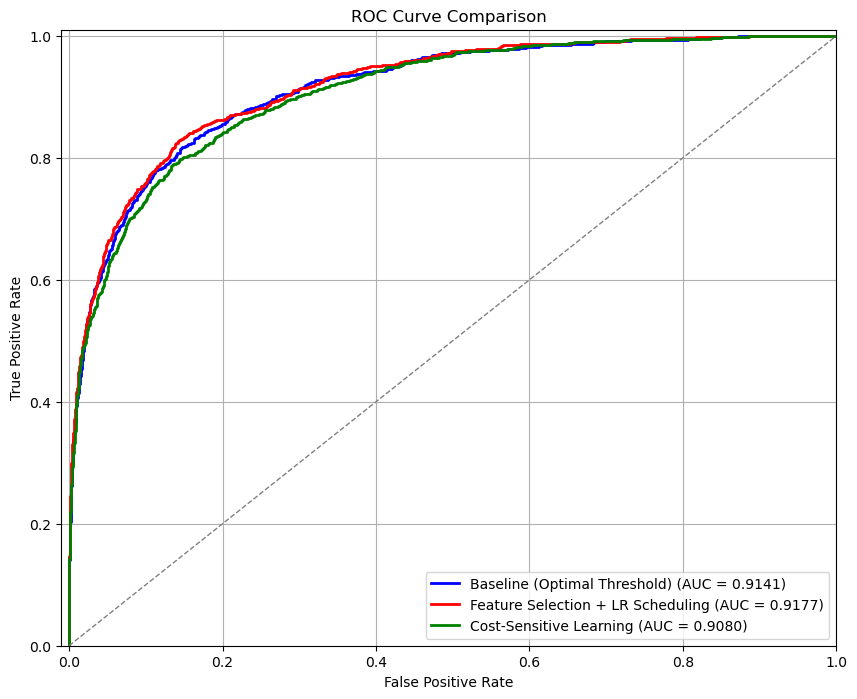


Comparison of Model Metrics:
                               Model  Accuracy  Precision (Churn)  \
0       Baseline (Optimal Threshold)  0.882196           0.695154   
1  Feature Selection + LR Scheduling  0.885928           0.706039   
2            Cost-Sensitive Learning  0.878998           0.692308   

   Recall (Churn)  F1 (Churn)  Threshold  
0        0.713382    0.704150   0.619969  
1        0.718807    0.712366   0.621488  
2        0.691682    0.691995   0.848060  


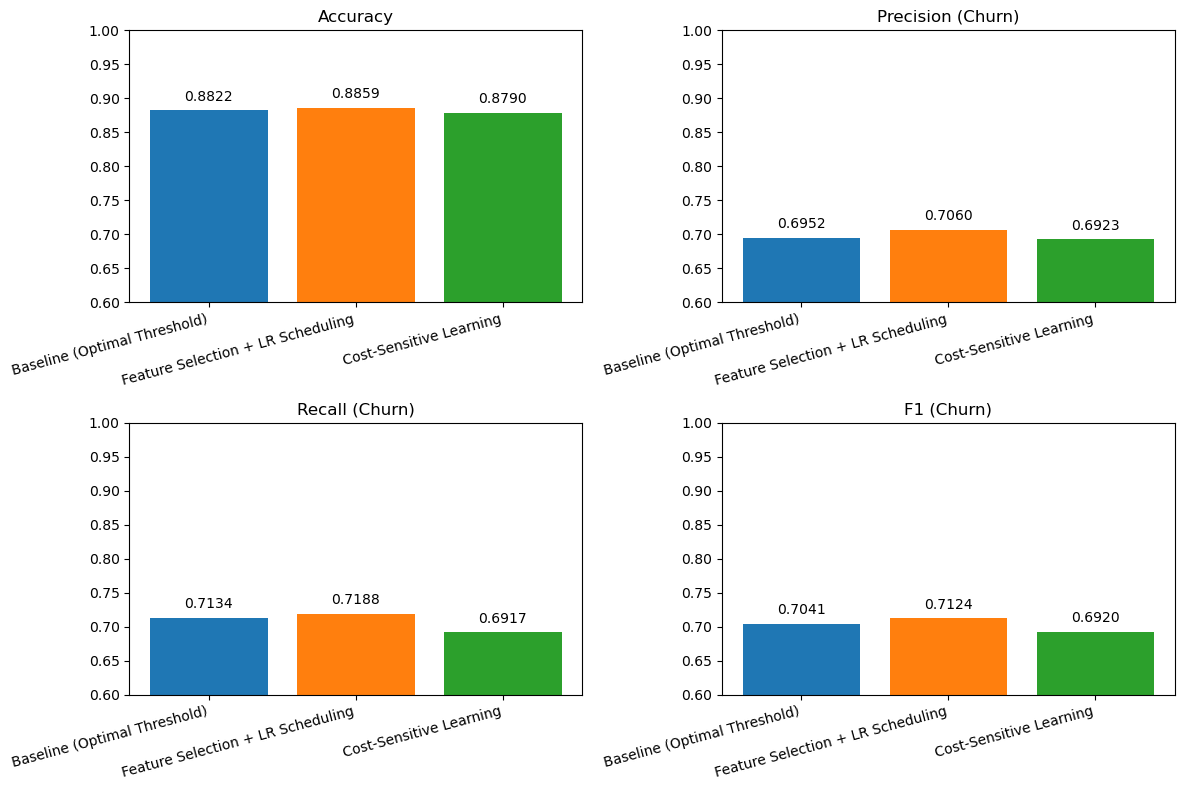


✅ Best model based on F1 score for churn: Feature Selection + LR Scheduling
   Accuracy: 0.8859
   Precision: 0.7060
   Recall: 0.7188
   F1 Score: 0.7124


In [205]:
    # MODEL VARIANT 2: Feature Selection + Learning Rate Scheduling
    print("\n=== MODEL VARIANT 2: Feature Selection + Learning Rate Scheduling ===")
    
    # Select top features based on SHAP importance from the baseline model
    top_n_features = 15  # Number of top features to select
    top_features = feature_importance['Feature'].head(top_n_features).tolist()
    
    print(f"Selected top {top_n_features} features for Model Variant 2:")
    for i, feature in enumerate(top_features):
        print(f"{i+1}. {feature}")
    
    # Create new datasets with only the selected top features
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]
    
    # Learning rate scheduling function
    def learning_rate_schedule(base_lr, iteration, total_iter=100):
        """Decreases learning rate as training progresses."""
        if iteration < total_iter * 0.5:
            return base_lr
        elif iteration < total_iter * 0.75:
            return base_lr * 0.5
        else:
            return base_lr * 0.1
    
    # Prepare DMatrices with feature-selected data
    dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train['CHURN'])
    dtest_selected = xgb.DMatrix(X_test_selected, label=y_test['CHURN'])
    
    # Use a copy of the final_params, learning rate will be adjusted by callback
    selected_params = final_params.copy()
    
    # XGBoost callback class for learning rate scheduling
    class LearningRateScheduler(xgb.callback.TrainingCallback):
        def __init__(self, base_lr, total_iter):
            self.base_lr = base_lr
            self.total_iter = total_iter
            self.current_iter = 0
            
        def after_iteration(self, model, epoch, evals_log):
            self.current_iter += 1
            new_lr = learning_rate_schedule(
                self.base_lr, 
                self.current_iter, 
                self.total_iter
            )
            model.set_param('learning_rate', str(new_lr)) # Update learning rate in the model
            return False # Necessary for XGBoost callback to continue training
    
    # Train model with feature selection and learning rate scheduling
    fs_model = xgb.train(
        selected_params,
        dtrain_selected,
        num_boost_round=best_num_rounds,
        evals=[(dtrain_selected, 'train'), (dtest_selected, 'eval')],
        early_stopping_rounds=10, # Early stopping if no improvement
        callbacks=[LearningRateScheduler(selected_params['eta'], best_num_rounds)],
        verbose_eval=True
    )
    
    # Evaluate the feature-selected model
    fs_pred = fs_model.predict(dtest_selected) # Get probability predictions
    
    # Find optimal threshold for the feature-selected model using precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test['CHURN'], fs_pred)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10) # Add epsilon to avoid division by zero
    optimal_idx = np.argmax(f1_scores)
    fs_optimal_threshold = thresholds[optimal_idx]
    print(f"Feature-selected model optimal threshold (max F1-score): {fs_optimal_threshold:.4f}")
    
    # Convert probabilities to binary predictions using the optimal threshold
    fs_pred_binary = (fs_pred > fs_optimal_threshold).astype(int)
    fs_accuracy = accuracy_score(y_test['CHURN'], fs_pred_binary)
    print(f"Feature-selected model accuracy (optimal threshold): {fs_accuracy:.4f}")
    print("Feature-selected model classification report (optimal threshold):")
    print(classification_report(y_test['CHURN'], fs_pred_binary))
    
    # MODEL VARIANT 3: Cost-Sensitive Learning with Class Weights
    print("\n=== MODEL VARIANT 3: Cost-Sensitive Learning with Class Weights ===")
    
    # Setup parameters for the cost-sensitive model
    cost_params = final_params.copy()
    
    # Calculate class weights based on inverse class frequency
    class_counts = y_train['CHURN'].value_counts()
    total_samples = len(y_train)
    weight_for_0 = (total_samples / (2 * class_counts[0])) # Weight for class 0 (non-churn)
    weight_for_1 = (total_samples / (2 * class_counts[1])) # Weight for class 1 (churn)
    
    print(f"Calculated class weights - Class 0: {weight_for_0:.4f}, Class 1: {weight_for_1:.4f}")
    
    # Assign calculated weights to each sample in the training set
    sample_weights = np.ones(len(y_train))
    sample_weights[y_train['CHURN'] == 0] = weight_for_0
    sample_weights[y_train['CHURN'] == 1] = weight_for_1
    
    # Create a DMatrix with sample weights for training
    dtrain_weighted = xgb.DMatrix(X_train, label=y_train['CHURN'], weight=sample_weights)
    
    # Set scale_pos_weight: ratio of negative class instances to positive class instances
    # This is another way to handle class imbalance in XGBoost
    cost_params['scale_pos_weight'] = class_counts[0] / class_counts[1] 
    
    # Train model with cost-sensitive learning (using weighted DMatrix and scale_pos_weight)
    cost_model = xgb.train(
        cost_params,
        dtrain_weighted, # Training data is weighted
        num_boost_round=best_num_rounds,
        evals=[(dtrain_weighted, 'train'), (dtest, 'eval')], # Evaluate on weighted train and unweighted test
        early_stopping_rounds=10,
        verbose_eval=True
    )
    
    # Evaluate the cost-sensitive model
    cost_pred = cost_model.predict(dtest) # Get probability predictions
    
    # Find optimal threshold for the cost-sensitive model
    precision, recall, thresholds = precision_recall_curve(y_test['CHURN'], cost_pred)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10) # Add epsilon
    optimal_idx = np.argmax(f1_scores)
    cost_optimal_threshold = thresholds[optimal_idx]
    print(f"Cost-sensitive model optimal threshold (max F1-score): {cost_optimal_threshold:.4f}")
    
    # Convert probabilities to binary predictions using the optimal threshold
    cost_pred_binary = (cost_pred > cost_optimal_threshold).astype(int)
    cost_accuracy = accuracy_score(y_test['CHURN'], cost_pred_binary)
    print(f"Cost-sensitive model accuracy (optimal threshold): {cost_accuracy:.4f}")
    print("Cost-sensitive model classification report (optimal threshold):")
    print(classification_report(y_test['CHURN'], cost_pred_binary))
    
    # MODEL COMPARISON
    print("\n=== MODEL COMPARISON ===")
    
    # Store model results for comparison
    models = {
        "Baseline (Optimal Threshold)": {
            "accuracy": baseline_accuracy,
            "predictions": baseline_pred_binary,
            "probability": baseline_pred_proba, # Probabilities from baseline model
            "threshold": optimal_threshold
        },
        "Feature Selection + LR Scheduling": {
            "accuracy": fs_accuracy,
            "predictions": fs_pred_binary,
            "probability": fs_pred, # Probabilities from feature selection model
            "threshold": fs_optimal_threshold
        },
        "Cost-Sensitive Learning": {
            "accuracy": cost_accuracy,
            "predictions": cost_pred_binary,
            "probability": cost_pred, # Probabilities from cost-sensitive model
            "threshold": cost_optimal_threshold
        }
    }
    
    # Plot ROC curves for all models to compare their discrimination ability
    from sklearn.metrics import roc_curve, auc # For ROC curve and AUC calculation
    
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green'] # Define colors for plotting ROC curves
    
    for i, (name, model_data) in enumerate(models.items()):
        fpr, tpr, _ = roc_curve(y_test['CHURN'], model_data["probability"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2,
                 label=f'{name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--') # Plot the diagonal line (random classifier)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve Comparison of Model Variants')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    # Create a summary table of key performance metrics
    metrics_table = []
    for name, model_data in models.items():
        report = classification_report(y_test['CHURN'], model_data["predictions"], output_dict=True)
        metrics_table.append({
            'Model': name,
            'Accuracy': model_data["accuracy"],
            'Precision (Churn)': report['1']['precision'], # Precision for the positive class (churn)
            'Recall (Churn)': report['1']['recall'],       # Recall for the positive class (churn)
            'F1 (Churn)': report['1']['f1-score'],         # F1-score for the positive class (churn)
            'Threshold': model_data["threshold"]
        })
    
    metrics_df = pd.DataFrame(metrics_table)
    print("\nComparison of Model Metrics (Focus on Churn Class):")
    print(metrics_df)
    
    # Visualize comparative metrics using a bar chart
    metrics_to_plot = ['Accuracy', 'Precision (Churn)', 'Recall (Churn)', 'F1 (Churn)']
    
    plt.figure(figsize=(14, 10)) # Adjusted figure size for better readability
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(2, 2, i+1)
        bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Define distinct colors for bars
        bars = plt.bar(metrics_df['Model'], metrics_df[metric], color=bar_colors)
        plt.title(f'Comparison of {metric}')
        plt.ylim(0.5, 1.0)  # Adjust y-axis for better visualization of metric differences
        plt.xticks(rotation=20, ha='right') # Rotate labels for better fit
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.005, # Adjusted offset
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout(pad=2.0) # Add padding
    plt.show()
    
    # Identify and print the best model based on F1 score for the churn class
    best_model_idx = metrics_df['F1 (Churn)'].argmax()
    best_model_name = metrics_df.iloc[best_model_idx]['Model']
    print(f"\n✅ Best performing model based on F1 score for churn: {best_model_name}")
    print(f"   Accuracy: {metrics_df.iloc[best_model_idx]['Accuracy']:.4f}")
    print(f"   Precision (Churn): {metrics_df.iloc[best_model_idx]['Precision (Churn)']:.4f}")
    print(f"   Recall (Churn): {metrics_df.iloc[best_model_idx]['Recall (Churn)']:.4f}")
    print(f"   F1 Score (Churn): {metrics_df.iloc[best_model_idx]['F1 (Churn)']:.4f}")

# XGBoost: Joint Hyperparameter and TruncatedSVD Optimization with Genetic Algorithm

/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Class distribution:
shape: (2, 1)
┌────────────┐
│ CHURN      │
│ ---        │
│ struct[2]  │
╞════════════╡
│ {0,205418} │
│ {1,39413}  │
└────────────┘
Scale pos weight: 5.211988582302569
Starting genetic algorithm optimization...
Using SVD with 2 components, explained variance: 1.0000
Using SVD with 21 components, explained variance: 1.0000
Using SVD with 25 components, explained variance: 1.0000
Using SVD with 14 components, explained variance: 1.0000
Using SVD with 2 components, explained variance: 1.0000
Using SVD with 2 components, explained variance: 1.0000
Using SVD with 25 components, explained variance: 1.0000
Using SVD with 15 components, explained variance: 1.0000
Using SVD with 31 components, explained variance: 1.0000
Using SVD with 19 components, explained variance: 1.0000
Using SVD with 31 components, explained variance: 1.0000
Using SVD with 2 components, explained variance: 1.0000
Using SVD with 8 components, explained variance: 1.0000
Using SVD with 15 components, e

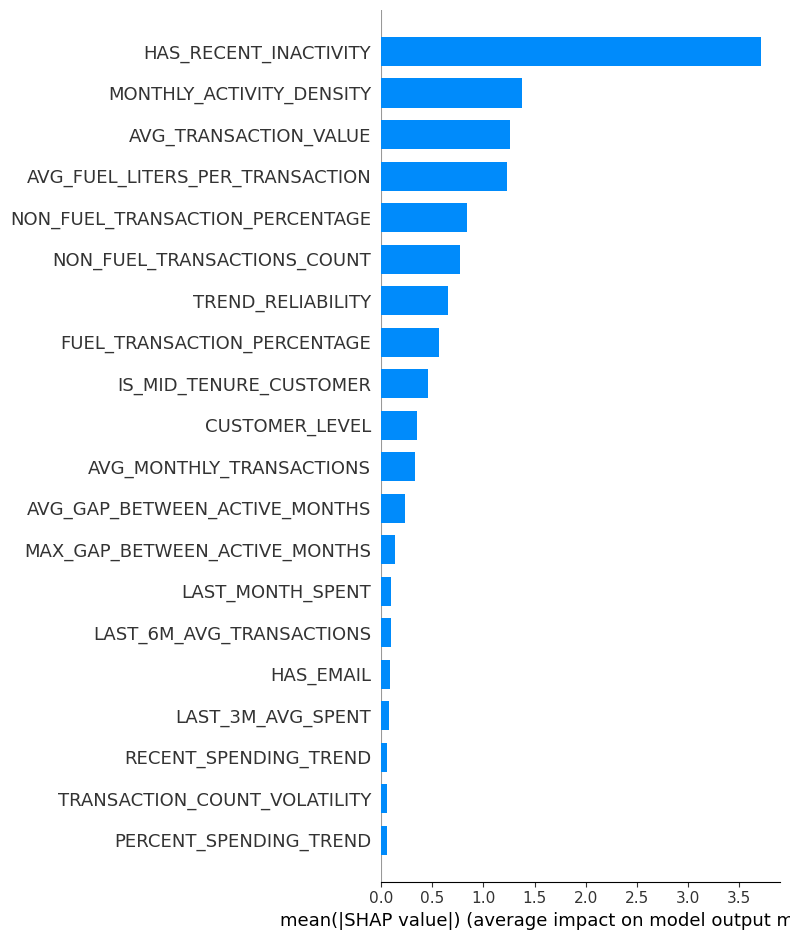

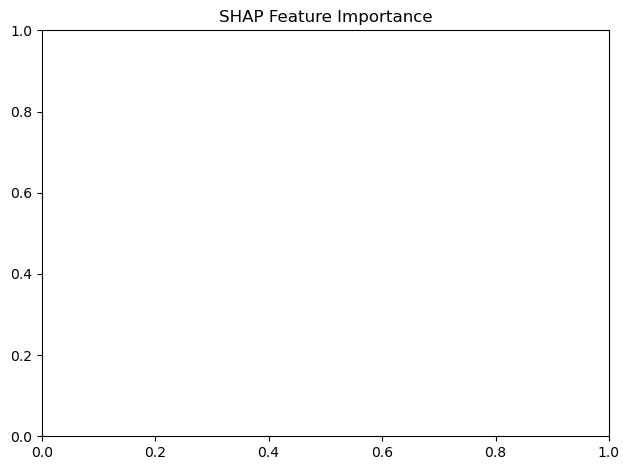

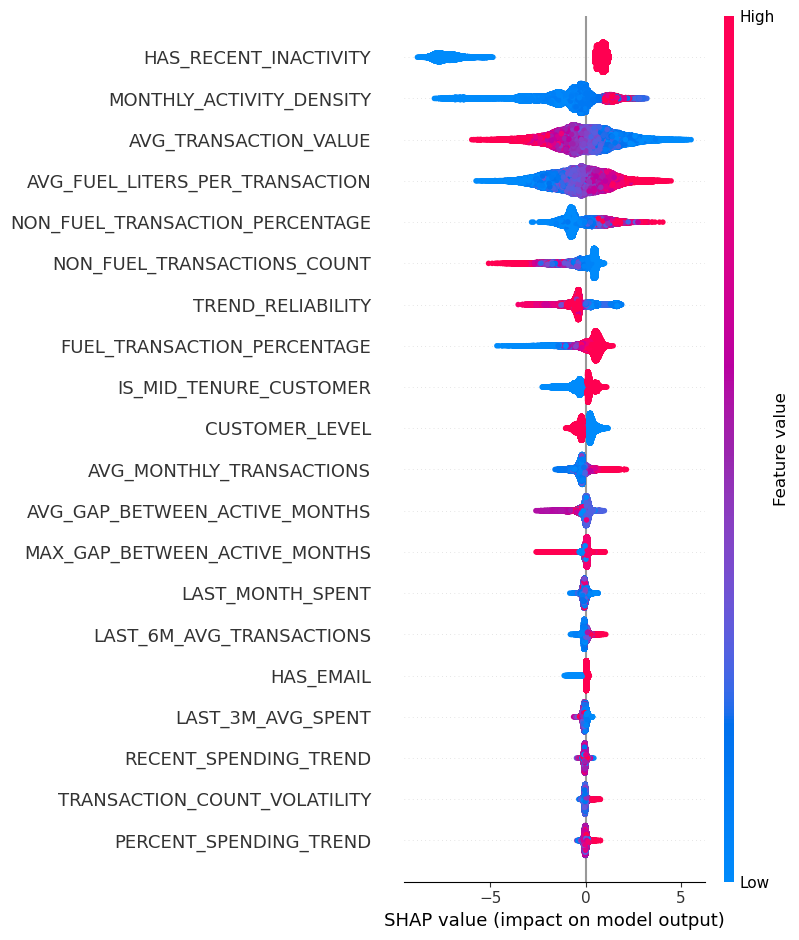

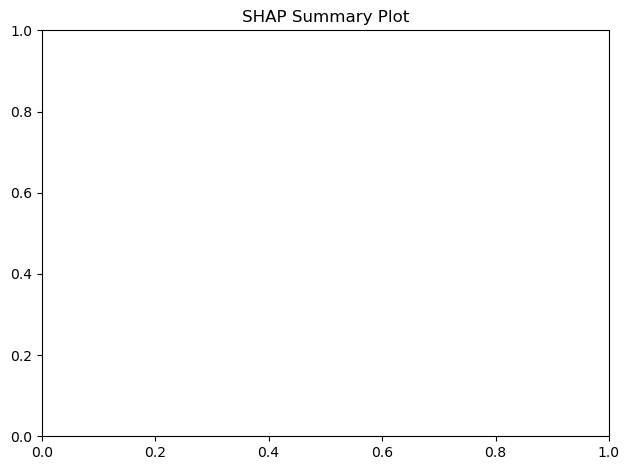


Top 10 features influencing churn:
                            Feature  Importance
31            HAS_RECENT_INACTIVITY    3.710304
19         MONTHLY_ACTIVITY_DENSITY    1.380329
5             AVG_TRANSACTION_VALUE    1.264030
36  AVG_FUEL_LITERS_PER_TRANSACTION    1.227370
35  NON_FUEL_TRANSACTION_PERCENTAGE    0.837895
6       NON_FUEL_TRANSACTIONS_COUNT    0.775850
27                TREND_RELIABILITY    0.656567
34      FUEL_TRANSACTION_PERCENTAGE    0.572350
25           IS_MID_TENURE_CUSTOMER    0.461397
1                    CUSTOMER_LEVEL    0.355586


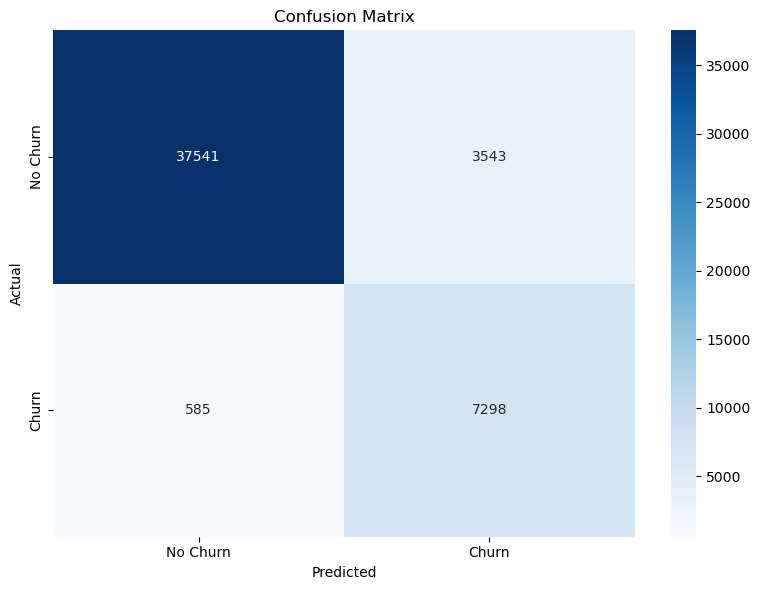


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95     41084
           1       0.67      0.93      0.78      7883

    accuracy                           0.92     48967
   macro avg       0.83      0.92      0.86     48967
weighted avg       0.93      0.92      0.92     48967

Model Accuracy: 0.9157


In [16]:
X = churn_features_df.select([col for col in churn_features_df.columns if col not in [
    "CHURN", "", "LATEST_TRANSACTION_DATE", "LAST_ACTIVE_MONTH", "MONTHS_SINCE_LAST_ACTIVITY",
    "ACTIVE_MONTHS", "MONTHS_AT_LEVEL", "CUSTOMER_TENURE_DAYS", "TOTAL_SPENT",
    "TOTAL_FUEL_LITERS", "TOTAL_TRANSACTIONS", "FUEL_TRANSACTIONS_COUNT",
    "LAST_TRANSACTION_DATE", "FIRST_ACTIVE_MONTH", "FIRST_TRANSACTION_DATE"
]])
y = churn_features_df.select("CHURN")

# Check class distribution
class_counts = y.select(pl.col("CHURN").value_counts()).sort("CHURN")
print("Class distribution:")
print(class_counts)

if len(class_counts) < 2:
    print("Error: Only one class present in the dataset. Cannot proceed with binary classification.")
else:
    # Split data into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X.to_pandas(),
        y.to_pandas(),
        test_size=0.2,
        random_state=42,
        stratify=y.to_pandas()
    )
    
    # Calculate scale_pos_weight to address class imbalance
    pos_weight = float((y_train['CHURN'] == 0).sum() / (y_train['CHURN'] == 1).sum())
    print(f"Scale pos weight: {pos_weight}")
    
    # Genetic Algorithm for Hyperparameter Tuning (GA-XGBoost with SVD)
    # Define evaluation function for GA: uses 3-fold CV on fewer rounds for speed.
    def eval_xgb(individual):
        # Unpack hyperparameters
        use_svd, n_components_ratio, max_depth, eta, min_child_weight, subsample, colsample_bytree = individual
        
        # Clip hyperparameters to their defined bounds
        eta = max(min(eta, 0.3), 0.01)
        min_child_weight = max(min(min_child_weight, 10), 1)
        subsample = max(min(subsample, 1.0), 0.5)
        colsample_bytree = max(min(colsample_bytree, 1.0), 0.5)
        
        use_svd_bool = use_svd > 0.5 # Determine if SVD should be used
        
        # Prepare features: apply SVD or use original features
        if use_svd_bool:
            # Calculate number of SVD components (at least 2, at most n_features-1 or n_samples-1)
            max_components = min(X_train.shape[1] - 1, X_train.shape[0] - 1)
            n_components = max(2, min(int(n_components_ratio * max_components), max_components))
            
            try:
                # Apply TruncatedSVD for dimensionality reduction
                svd = TruncatedSVD(n_components=n_components, random_state=42)
                X_train_transformed = svd.fit_transform(X_train)
                explained_var = svd.explained_variance_ratio_.sum()
                print(f"GA Eval: Using SVD with {n_components} components, explained variance: {explained_var:.4f}")
                
                dtrain = xgb.DMatrix(X_train_transformed, label=y_train['CHURN'])
            except Exception as e:
                print(f"GA Eval SVD error: {e}, falling back to original features")
                dtrain = xgb.DMatrix(X_train, label=y_train['CHURN'])
        else:
            dtrain = xgb.DMatrix(X_train, label=y_train['CHURN']) # Use original features
        
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': int(max_depth),
            'eta': eta,
            'min_child_weight': min_child_weight,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'seed': 42,
            'scale_pos_weight': pos_weight
        }
        
        try:
            cv_results = xgb.cv(
                params=params,
                dtrain=dtrain,
                num_boost_round=100,  # Fewer rounds for faster GA evaluation
                nfold=3,
                stratified=True,
                early_stopping_rounds=5,
                metrics='auc',
                seed=42,
                verbose_eval=False
            )
            best_auc = cv_results['test-auc-mean'].max()
        except Exception as e:
            print(f"GA Eval CV error: {e}")
            best_auc = 0.5  # Default to random performance if an error occurs
            
        # DEAP minimizes fitness; return negative AUC to maximize AUC.
        return -best_auc,
    
    # Set up DEAP for Genetic Algorithm optimization
    # Recreate FitnessMin and Individual if they exist from previous runs to avoid errors
    if 'FitnessMin' in dir(creator):
        del creator.FitnessMin
        del creator.Individual
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Objective: Minimize negative AUC (i.e., maximize AUC)
    creator.create("Individual", list, fitness=creator.FitnessMin)
    
    toolbox = base.Toolbox()
    # Define attribute generators for hyperparameters, including SVD parameters
    toolbox.register("use_svd", random.random)  # Float 0-1, will be thresholded to boolean
    toolbox.register("n_components_ratio", random.random)  # Float 0-1, scaled to actual number of components
    toolbox.register("max_depth", random.randint, 3, 10)
    toolbox.register("eta", random.uniform, 0.01, 0.3)
    toolbox.register("min_child_weight", random.uniform, 1, 10)
    toolbox.register("subsample", random.uniform, 0.5, 1.0)
    toolbox.register("colsample_bytree", random.uniform, 0.5, 1.0)
    
    # Create individuals and population, including SVD-related parameters
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.use_svd, toolbox.n_components_ratio, toolbox.max_depth, 
                      toolbox.eta, toolbox.min_child_weight, toolbox.subsample, 
                      toolbox.colsample_bytree), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    # Register genetic operators
    toolbox.register("evaluate", eval_xgb)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover operator
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)  # Mutation operator
    toolbox.register("select", tools.selTournament, tournsize=3)  # Selection operator
    
    # Configure statistics to track GA progress
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    random.seed(42) # For reproducibility
    population = toolbox.population(n=30) 
    ngen = 15  # Number of generations
    cxpb = 0.5  # Crossover probability
    mutpb = 0.2 # Mutation probability
    
    # Run Genetic Algorithm optimization
    print("Starting genetic algorithm optimization...")
    hof = tools.HallOfFame(1) # Stores the best individual found
    algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=hof, verbose=True)
    
    best_ga_params = hof[0] # Best individual's parameters
    print("Best hyperparameters found by GA:", best_ga_params)
    
    # Unpack the best parameters found by GA
    use_svd = best_ga_params[0] > 0.5
    n_components_ratio = best_ga_params[1]
    
    # Set final XGBoost parameters using the best GA results, ensuring they are within valid ranges
    final_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': int(best_ga_params[2]),
        'eta': max(min(best_ga_params[3], 0.3), 0.01),
        'min_child_weight': max(min(best_ga_params[4], 10), 1),
        'subsample': max(min(best_ga_params[5], 1.0), 0.5),
        'colsample_bytree': max(min(best_ga_params[6], 1.0), 0.5),
        'seed': 42,
        'scale_pos_weight': pos_weight
    }
    
    print("Final hyperparameters for model training:")
    for key, value in final_params.items():
        print(f"{key}: {value}")
    print(f"use_svd: {use_svd}") # Whether SVD will be used for the final model
    
    # Prepare final features for training and testing (with or without SVD) based on GA optimization
    if use_svd:
        max_components = min(X_train.shape[1] - 1, X_train.shape[0] - 1)
        n_components = max(2, min(int(n_components_ratio * max_components), max_components))
        print(f"Final model: Using SVD with {n_components} components")
        
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        X_train_final = svd.fit_transform(X_train)
        X_test_final = svd.transform(X_test)
        
        explained_var = svd.explained_variance_ratio_.sum()
        print(f"Final model SVD explained variance: {explained_var:.4f}")
        
        print(f"Original feature shape: {X_train.shape}")
        print(f"Transformed feature shape (SVD): {X_train_final.shape}")
        
        feature_names = [f"SVD_Component_{i+1}" for i in range(n_components)] # Generate names for SVD components
    else:
        X_train_final = X_train
        X_test_final = X_test
        feature_names = X_train.columns.tolist() # Use original feature names
        print("Final model: Using original features (no SVD)")
    
    # Cross-Validation with Optimized Hyperparameters to find the best number of boosting rounds
    dtrain_final = xgb.DMatrix(X_train_final, label=y_train['CHURN'], feature_names=feature_names if use_svd else None)
    cv_results = xgb.cv(
        params=final_params,
        dtrain=dtrain_final,
        num_boost_round=200, # Maximum number of boosting rounds for CV
        nfold=5,
        stratified=True,
        early_stopping_rounds=10,
        metrics='auc',
        seed=42,
        verbose_eval=True
    )
    best_num_rounds = cv_results.shape[0] # Optimal number of boosting rounds from CV
    print(f"Best number of rounds from CV: {best_num_rounds}")
    
    # Train final XGBoost model with optimized hyperparameters and number of rounds
    dtest_final = xgb.DMatrix(X_test_final, label=y_test['CHURN'], feature_names=feature_names if use_svd else None)
    bst = xgb.train(
        final_params,
        dtrain_final,
        num_boost_round=best_num_rounds,
        evals=[(dtrain_final, 'train'), (dtest_final, 'eval')],
        early_stopping_rounds=10, # Stop training if eval metric doesn't improve
        verbose_eval=True
    )
    
    # Model Evaluation and SHAP Interpretability
    y_pred_proba = bst.predict(dtest_final) # Predicted probabilities
    auc_value = roc_auc_score(y_test['CHURN'], y_pred_proba)
    print(f"\nFinal Test AUC: {auc_value:.4f}")
    
    # SHAP analysis for feature importance and model interpretability
    try:
        explainer = shap.TreeExplainer(bst)
        # For TreeExplainer, pass the data used for prediction (X_test_final)
        # If X_test_final is a NumPy array (SVD case), SHAP handles it.
        # If X_test_final is a Pandas DataFrame (no SVD), SHAP handles it.
        shap_values = explainer.shap_values(X_test_final) 
        
        # Create DataFrame for SHAP plotting with appropriate feature names
        if isinstance(X_test_final, np.ndarray): # SVD case, X_test_final is numpy array
             X_test_df_for_shap = pd.DataFrame(X_test_final, columns=feature_names)
        else: # No SVD, X_test_final is a pandas DataFrame
             X_test_df_for_shap = X_test_final

        # SHAP summary plot (bar)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_df_for_shap, plot_type="bar")
        plt.title("SHAP Feature Importance (Bar Plot)")
        plt.tight_layout()
        plt.show()
        
        # SHAP summary plot (dot)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_df_for_shap)
        plt.title("SHAP Summary Plot (Dot Plot)")
        plt.tight_layout()
        plt.show()
        
        # Calculate feature importance from SHAP values
        shap_feature_importance = pd.DataFrame({
            'Feature': feature_names, # SVD component names or original feature names
            'Importance': np.abs(shap_values).mean(0)
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 features influencing churn (based on SHAP values):")
        print(shap_feature_importance.head(10))
        
        # If SVD was used, show original feature contributions to top SVD components
        if use_svd:
            print("\nTop SVD components and their most important original features (from SVD model's components):")
            for i in range(min(3, n_components)): # Display for top 3 components or fewer if n_components < 3
                component_idx = i
                # svd.components_ shows the principal axes in the original feature space
                component_weights = pd.DataFrame({
                    'Original_Feature': X_train.columns, # Names of features before SVD
                    'Weight_in_SVD_Component': np.abs(svd.components_[component_idx])
                }).sort_values('Weight_in_SVD_Component', ascending=False)
                
                print(f"\nSVD_Component_{i+1} top original features by weight:")
                print(component_weights.head(5))
    except Exception as e:
        print(f"SHAP analysis error: {e}")
    
    # Prepare confusion matrix and classification report using a default 0.5 threshold
    y_pred_binary = (y_pred_proba > 0.5).astype(int) # Convert probabilities to binary predictions
    conf_matrix = confusion_matrix(y_test['CHURN'], y_pred_binary)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Threshold 0.5)')
    plt.tight_layout()
    plt.show()
    
    # Classification metrics
    print("\nClassification Report (Threshold 0.5):")
    print(classification_report(y_test['CHURN'], y_pred_binary))
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test['CHURN'], y_pred_binary)
    print(f"Model Accuracy (Threshold 0.5): {accuracy:.4f}")

# XGBoost with Optuna, Optional Truncated SVD, and Automated Threshold Selection

[I 2025-03-12 16:36:59,165] A new study created in memory with name: xgboost_churn_prediction


Class distribution:
shape: (2, 1)
┌───────────┐
│ CHURN     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {0,22607} │
│ {1,5529}  │
└───────────┘
Scale pos weight: 4.088853719195116
Starting Optuna optimization...


[I 2025-03-12 16:37:00,999] Trial 0 finished with value: 0.8803074329419597 and parameters: {'use_svd': False, 'max_depth': 5, 'eta': 0.12382925518346917, 'min_child_weight': 3.3817054459914533, 'subsample': 0.9746368365342377, 'colsample_bytree': 0.6729959094514572}. Best is trial 0 with value: 0.8803074329419597.


Trial 1: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:37:03,799] Trial 1 finished with value: 0.8938147030893381 and parameters: {'use_svd': True, 'n_components_ratio': 0.8080252928046254, 'max_depth': 5, 'eta': 0.07958127921655737, 'min_child_weight': 4.9531194861541845, 'subsample': 0.7945319888671061, 'colsample_bytree': 0.6137045854749538}. Best is trial 1 with value: 0.8938147030893381.
[I 2025-03-12 16:37:05,528] Trial 2 finished with value: 0.8421020357588814 and parameters: {'use_svd': False, 'max_depth': 10, 'eta': 0.037425403632213465, 'min_child_weight': 4.184542484523664, 'subsample': 0.7965501104572441, 'colsample_bytree': 0.7154713138566418}. Best is trial 1 with value: 0.8938147030893381.


Trial 3: Using SVD with 24 components, explained variance: 1.0000


[I 2025-03-12 16:37:09,899] Trial 3 finished with value: 0.8918382091802503 and parameters: {'use_svd': True, 'n_components_ratio': 0.6790190110120962, 'max_depth': 8, 'eta': 0.0641620601854618, 'min_child_weight': 2.7023548054794135, 'subsample': 0.93944019171026, 'colsample_bytree': 0.915716506076703}. Best is trial 1 with value: 0.8938147030893381.


Trial 4: Using SVD with 14 components, explained variance: 1.0000


[I 2025-03-12 16:37:10,832] Trial 4 finished with value: 0.8314608625237039 and parameters: {'use_svd': True, 'n_components_ratio': 0.39585527314482494, 'max_depth': 7, 'eta': 0.2822862748081178, 'min_child_weight': 4.326151688939306, 'subsample': 0.7034825047108324, 'colsample_bytree': 0.6712315972021637}. Best is trial 1 with value: 0.8938147030893381.


Trial 5: Using SVD with 6 components, explained variance: 1.0000


[I 2025-03-12 16:37:11,449] Trial 5 finished with value: 0.6744443692712077 and parameters: {'use_svd': True, 'n_components_ratio': 0.17921501713334448, 'max_depth': 4, 'eta': 0.01656225310237299, 'min_child_weight': 7.878422692138808, 'subsample': 0.8015423768540934, 'colsample_bytree': 0.6452692702955636}. Best is trial 1 with value: 0.8938147030893381.
[I 2025-03-12 16:37:13,266] Trial 6 finished with value: 0.8468706566270594 and parameters: {'use_svd': False, 'max_depth': 10, 'eta': 0.03898580697179592, 'min_child_weight': 9.459242787121653, 'subsample': 0.9112785710969453, 'colsample_bytree': 0.8225867557592097}. Best is trial 1 with value: 0.8938147030893381.


Trial 7: Using SVD with 18 components, explained variance: 1.0000


[I 2025-03-12 16:37:15,715] Trial 7 finished with value: 0.8151170846172362 and parameters: {'use_svd': True, 'n_components_ratio': 0.5165421385104145, 'max_depth': 4, 'eta': 0.011102357974669722, 'min_child_weight': 5.165070311236636, 'subsample': 0.8399533754601347, 'colsample_bytree': 0.6772013716141378}. Best is trial 1 with value: 0.8938147030893381.


Trial 8: Using SVD with 11 components, explained variance: 1.0000


[I 2025-03-12 16:37:17,449] Trial 8 finished with value: 0.7364862864632001 and parameters: {'use_svd': True, 'n_components_ratio': 0.33319496123005693, 'max_depth': 9, 'eta': 0.01909392783357846, 'min_child_weight': 5.253249760465225, 'subsample': 0.9684533342444571, 'colsample_bytree': 0.7188614220354717}. Best is trial 1 with value: 0.8938147030893381.


Trial 9: Using SVD with 6 components, explained variance: 1.0000


[I 2025-03-12 16:37:19,699] Trial 9 finished with value: 0.6984354304761903 and parameters: {'use_svd': True, 'n_components_ratio': 0.17061770639253487, 'max_depth': 4, 'eta': 0.08090698831832135, 'min_child_weight': 4.264777377911038, 'subsample': 0.6609803462676885, 'colsample_bytree': 0.6116137471664629}. Best is trial 1 with value: 0.8938147030893381.
[I 2025-03-12 16:37:21,749] Trial 10 finished with value: 0.8783949937036195 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.19074897481300374, 'min_child_weight': 1.362183727368194, 'subsample': 0.5435294866808165, 'colsample_bytree': 0.5405043261213651}. Best is trial 1 with value: 0.8938147030893381.


Trial 11: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:37:26,382] Trial 11 finished with value: 0.8975928685349824 and parameters: {'use_svd': True, 'n_components_ratio': 0.8410393910079688, 'max_depth': 8, 'eta': 0.07952151056554892, 'min_child_weight': 1.9633825545443324, 'subsample': 0.8845801990848704, 'colsample_bytree': 0.9646873647198995}. Best is trial 11 with value: 0.8975928685349824.


Trial 12: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:37:29,532] Trial 12 finished with value: 0.9052171595344246 and parameters: {'use_svd': True, 'n_components_ratio': 0.8968674366352629, 'max_depth': 7, 'eta': 0.11396963555411446, 'min_child_weight': 7.437318388347548, 'subsample': 0.8672371472854492, 'colsample_bytree': 0.9994868659517894}. Best is trial 12 with value: 0.9052171595344246.


Trial 13: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:37:33,499] Trial 13 finished with value: 0.897688727430285 and parameters: {'use_svd': True, 'n_components_ratio': 0.868489852663027, 'max_depth': 8, 'eta': 0.13540427517070003, 'min_child_weight': 7.112811175393357, 'subsample': 0.8774282570894705, 'colsample_bytree': 0.9662369186832209}. Best is trial 12 with value: 0.9052171595344246.


Trial 14: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:37:37,215] Trial 14 finished with value: 0.9056528111255945 and parameters: {'use_svd': True, 'n_components_ratio': 0.899390028135585, 'max_depth': 7, 'eta': 0.1427357542932098, 'min_child_weight': 7.029898909400329, 'subsample': 0.7219894646900861, 'colsample_bytree': 0.8431063431412507}. Best is trial 14 with value: 0.9056528111255945.


Trial 15: Using SVD with 23 components, explained variance: 1.0000


[I 2025-03-12 16:37:38,915] Trial 15 finished with value: 0.8892819074154779 and parameters: {'use_svd': True, 'n_components_ratio': 0.6524239307666231, 'max_depth': 6, 'eta': 0.13928335190683844, 'min_child_weight': 6.805459350289856, 'subsample': 0.624568968040879, 'colsample_bytree': 0.8289535448329373}. Best is trial 14 with value: 0.9056528111255945.


Trial 16: Using SVD with 25 components, explained variance: 1.0000


[I 2025-03-12 16:37:40,166] Trial 16 finished with value: 0.881712893561296 and parameters: {'use_svd': True, 'n_components_ratio': 0.7051270622519709, 'max_depth': 7, 'eta': 0.29865874827879174, 'min_child_weight': 8.98103376525513, 'subsample': 0.7402934043161244, 'colsample_bytree': 0.8636616049096199}. Best is trial 14 with value: 0.9056528111255945.


Trial 17: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:37:42,482] Trial 17 finished with value: 0.901945580331834 and parameters: {'use_svd': True, 'n_components_ratio': 0.899116832140647, 'max_depth': 7, 'eta': 0.18454571355621058, 'min_child_weight': 6.634849884626964, 'subsample': 0.5884810021208713, 'colsample_bytree': 0.783468149934121}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:37:46,782] Trial 18 finished with value: 0.8936648299965001 and parameters: {'use_svd': False, 'max_depth': 9, 'eta': 0.05231702990139709, 'min_child_weight': 8.596387881055483, 'subsample': 0.6955644449671669, 'colsample_bytree': 0.8985926862838864}. Best is trial 14 with value: 0.9056528111255945.


Trial 19: Using SVD with 20 components, explained variance: 1.0000


[I 2025-03-12 16:37:49,165] Trial 19 finished with value: 0.8546992582122032 and parameters: {'use_svd': True, 'n_components_ratio': 0.57697756023549, 'max_depth': 3, 'eta': 0.18930096671502455, 'min_child_weight': 6.081112898482063, 'subsample': 0.7512454102156049, 'colsample_bytree': 0.9916707634273708}. Best is trial 14 with value: 0.9056528111255945.


Trial 20: Using SVD with 28 components, explained variance: 1.0000


[I 2025-03-12 16:37:52,382] Trial 20 finished with value: 0.8940974374174401 and parameters: {'use_svd': True, 'n_components_ratio': 0.7824298468729861, 'max_depth': 6, 'eta': 0.10257632854929062, 'min_child_weight': 7.909158738666482, 'subsample': 0.8524892787493299, 'colsample_bytree': 0.9265279108485018}. Best is trial 14 with value: 0.9056528111255945.


Trial 21: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:37:54,799] Trial 21 finished with value: 0.898692331673126 and parameters: {'use_svd': True, 'n_components_ratio': 0.8962062330838099, 'max_depth': 7, 'eta': 0.20032947122703204, 'min_child_weight': 6.3008721467288655, 'subsample': 0.5351941994804017, 'colsample_bytree': 0.785993203571419}. Best is trial 14 with value: 0.9056528111255945.


Trial 22: Using SVD with 27 components, explained variance: 1.0000


[I 2025-03-12 16:37:56,682] Trial 22 finished with value: 0.8884819138846097 and parameters: {'use_svd': True, 'n_components_ratio': 0.7732359490491986, 'max_depth': 7, 'eta': 0.17621112402125197, 'min_child_weight': 7.494964762324484, 'subsample': 0.6121381050060233, 'colsample_bytree': 0.7791267962928872}. Best is trial 14 with value: 0.9056528111255945.


Trial 23: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:38:00,482] Trial 23 finished with value: 0.9049540610574126 and parameters: {'use_svd': True, 'n_components_ratio': 0.8977643683850431, 'max_depth': 8, 'eta': 0.11097500420367615, 'min_child_weight': 6.238556049085367, 'subsample': 0.6000973397241711, 'colsample_bytree': 0.8635085158975655}. Best is trial 14 with value: 0.9056528111255945.


Trial 24: Using SVD with 27 components, explained variance: 1.0000


[I 2025-03-12 16:38:03,716] Trial 24 finished with value: 0.8907366816917537 and parameters: {'use_svd': True, 'n_components_ratio': 0.7607300214551348, 'max_depth': 9, 'eta': 0.10182817497549382, 'min_child_weight': 5.922480894900639, 'subsample': 0.5003709906661411, 'colsample_bytree': 0.8655116493340463}. Best is trial 14 with value: 0.9056528111255945.


Trial 25: Using SVD with 21 components, explained variance: 1.0000


[I 2025-03-12 16:38:07,732] Trial 25 finished with value: 0.8799300006654752 and parameters: {'use_svd': True, 'n_components_ratio': 0.6091257701996224, 'max_depth': 8, 'eta': 0.052021570537330995, 'min_child_weight': 8.202899692157994, 'subsample': 0.649618259614559, 'colsample_bytree': 0.8714775162290558}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:38:11,415] Trial 26 finished with value: 0.9024178898037593 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.10637374622656642, 'min_child_weight': 9.725033834112159, 'subsample': 0.7258406099494692, 'colsample_bytree': 0.9407256073879022}. Best is trial 14 with value: 0.9056528111255945.


Trial 27: Using SVD with 26 components, explained variance: 1.0000


[I 2025-03-12 16:38:13,982] Trial 27 finished with value: 0.8928034644769237 and parameters: {'use_svd': True, 'n_components_ratio': 0.7328032623800235, 'max_depth': 6, 'eta': 0.13352795323317498, 'min_child_weight': 7.143890304280345, 'subsample': 0.5756717714187084, 'colsample_bytree': 0.9955194505601724}. Best is trial 14 with value: 0.9056528111255945.


Trial 28: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:38:16,016] Trial 28 finished with value: 0.8892817148898455 and parameters: {'use_svd': True, 'n_components_ratio': 0.8372008219207131, 'max_depth': 9, 'eta': 0.2360727856958784, 'min_child_weight': 5.638313254311748, 'subsample': 0.690642186421049, 'colsample_bytree': 0.8247081670860259}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:38:19,232] Trial 29 finished with value: 0.892321150905015 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.06596271959274114, 'min_child_weight': 8.859832374077351, 'subsample': 0.7599166280617935, 'colsample_bytree': 0.8876453575201391}. Best is trial 14 with value: 0.9056528111255945.


Trial 30: Using SVD with 15 components, explained variance: 1.0000


[I 2025-03-12 16:38:20,816] Trial 30 finished with value: 0.8440214745099478 and parameters: {'use_svd': True, 'n_components_ratio': 0.42039261700062447, 'max_depth': 5, 'eta': 0.14711763757961252, 'min_child_weight': 3.37324472537795, 'subsample': 0.9864584663072304, 'colsample_bytree': 0.7492618491946513}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:38:24,549] Trial 31 finished with value: 0.9032644438456842 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.10713846343029358, 'min_child_weight': 9.99254101190388, 'subsample': 0.7309605950799934, 'colsample_bytree': 0.9514487371150215}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:38:28,232] Trial 32 finished with value: 0.9019413421516269 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.11088468228511623, 'min_child_weight': 8.342076415037377, 'subsample': 0.6613607510607639, 'colsample_bytree': 0.9544744677926121}. Best is trial 14 with value: 0.9056528111255945.
[I 202

Trial 37: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:38:44,149] Trial 37 finished with value: 0.8828318175407744 and parameters: {'use_svd': True, 'n_components_ratio': 0.8234338117032571, 'max_depth': 5, 'eta': 0.028589229761357533, 'min_child_weight': 3.6627405732757414, 'subsample': 0.820124345438403, 'colsample_bytree': 0.9084141279748817}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:38:46,777] Trial 38 finished with value: 0.9015926836204079 and parameters: {'use_svd': False, 'max_depth': 7, 'eta': 0.23834346503975515, 'min_child_weight': 9.127006026413245, 'subsample': 0.9340897098917618, 'colsample_bytree': 0.9986685472866599}. Best is trial 14 with value: 0.9056528111255945.


Trial 39: Using SVD with 9 components, explained variance: 1.0000


[I 2025-03-12 16:38:47,516] Trial 39 finished with value: 0.6989087083090015 and parameters: {'use_svd': True, 'n_components_ratio': 0.2733258133999709, 'max_depth': 7, 'eta': 0.08740618536001082, 'min_child_weight': 5.825071069507815, 'subsample': 0.6785289690264911, 'colsample_bytree': 0.8865036687021074}. Best is trial 14 with value: 0.9056528111255945.


Trial 40: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:38:51,783] Trial 40 finished with value: 0.904235552651106 and parameters: {'use_svd': True, 'n_components_ratio': 0.8980003267007678, 'max_depth': 8, 'eta': 0.11637603023380305, 'min_child_weight': 5.034091099221776, 'subsample': 0.6388120927751275, 'colsample_bytree': 0.808327804786744}. Best is trial 14 with value: 0.9056528111255945.


Trial 41: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:38:55,379] Trial 41 finished with value: 0.9044442569772984 and parameters: {'use_svd': True, 'n_components_ratio': 0.8988058238816228, 'max_depth': 8, 'eta': 0.11936160030969356, 'min_child_weight': 5.1104270131896525, 'subsample': 0.592486780671281, 'colsample_bytree': 0.8105529644594286}. Best is trial 14 with value: 0.9056528111255945.


Trial 42: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:38:59,116] Trial 42 finished with value: 0.9036554335415982 and parameters: {'use_svd': True, 'n_components_ratio': 0.899486608074348, 'max_depth': 8, 'eta': 0.11675453250952571, 'min_child_weight': 4.7742726893942145, 'subsample': 0.5809254489094547, 'colsample_bytree': 0.7503936999413033}. Best is trial 14 with value: 0.9056528111255945.


Trial 43: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:39:01,832] Trial 43 finished with value: 0.8923453529166151 and parameters: {'use_svd': True, 'n_components_ratio': 0.8352545816643389, 'max_depth': 9, 'eta': 0.16264236048797498, 'min_child_weight': 5.204104712414852, 'subsample': 0.6238004988554554, 'colsample_bytree': 0.8002171060962546}. Best is trial 14 with value: 0.9056528111255945.


Trial 44: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:39:03,999] Trial 44 finished with value: 0.8867946757278635 and parameters: {'use_svd': True, 'n_components_ratio': 0.860210077158393, 'max_depth': 8, 'eta': 0.23374135056774697, 'min_child_weight': 3.9834360291172866, 'subsample': 0.6027414581830168, 'colsample_bytree': 0.744488982212648}. Best is trial 14 with value: 0.9056528111255945.


Trial 45: Using SVD with 28 components, explained variance: 1.0000


[I 2025-03-12 16:39:07,616] Trial 45 finished with value: 0.8938752667744264 and parameters: {'use_svd': True, 'n_components_ratio': 0.7867262299036915, 'max_depth': 7, 'eta': 0.07168295147397144, 'min_child_weight': 5.481768655702394, 'subsample': 0.6429808203163409, 'colsample_bytree': 0.6940214121742292}. Best is trial 14 with value: 0.9056528111255945.


Trial 46: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:39:13,098] Trial 46 finished with value: 0.8932484040411416 and parameters: {'use_svd': True, 'n_components_ratio': 0.8114910126703441, 'max_depth': 10, 'eta': 0.08933389474376467, 'min_child_weight': 2.988513977405302, 'subsample': 0.5505085758037265, 'colsample_bytree': 0.8056660898805243}. Best is trial 14 with value: 0.9056528111255945.


Trial 47: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:39:16,633] Trial 47 finished with value: 0.9035082110945406 and parameters: {'use_svd': True, 'n_components_ratio': 0.8942639382425469, 'max_depth': 9, 'eta': 0.13061589706396196, 'min_child_weight': 6.959506963440903, 'subsample': 0.5595473706267073, 'colsample_bytree': 0.844540888182816}. Best is trial 14 with value: 0.9056528111255945.


Trial 48: Using SVD with 26 components, explained variance: 1.0000


[I 2025-03-12 16:39:19,833] Trial 48 finished with value: 0.8907148968196346 and parameters: {'use_svd': True, 'n_components_ratio': 0.7283409727128609, 'max_depth': 6, 'eta': 0.04463496863717794, 'min_child_weight': 4.815150163264164, 'subsample': 0.6376239907278702, 'colsample_bytree': 0.7200687338359527}. Best is trial 14 with value: 0.9056528111255945.


Trial 49: Using SVD with 28 components, explained variance: 1.0000


[I 2025-03-12 16:39:23,668] Trial 49 finished with value: 0.8922548931943218 and parameters: {'use_svd': True, 'n_components_ratio': 0.8051017841066351, 'max_depth': 8, 'eta': 0.05799850023862661, 'min_child_weight': 7.332998370160129, 'subsample': 0.5126218405069007, 'colsample_bytree': 0.5115953134692162}. Best is trial 14 with value: 0.9056528111255945.


Trial 50: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:39:26,649] Trial 50 finished with value: 0.8966530717018596 and parameters: {'use_svd': True, 'n_components_ratio': 0.8536473701689762, 'max_depth': 7, 'eta': 0.1191342462471661, 'min_child_weight': 6.221277817027908, 'subsample': 0.6721265982353035, 'colsample_bytree': 0.5961789900769972}. Best is trial 14 with value: 0.9056528111255945.


Trial 51: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:39:29,816] Trial 51 finished with value: 0.8958765529732639 and parameters: {'use_svd': True, 'n_components_ratio': 0.8808059200712045, 'max_depth': 8, 'eta': 0.12205413994768938, 'min_child_weight': 4.75140252455427, 'subsample': 0.5857277095042427, 'colsample_bytree': 0.7641474134477689}. Best is trial 14 with value: 0.9056528111255945.


Trial 52: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:39:33,214] Trial 52 finished with value: 0.9009591498568866 and parameters: {'use_svd': True, 'n_components_ratio': 0.8984601657654854, 'max_depth': 8, 'eta': 0.1640224597320977, 'min_child_weight': 4.375981487773556, 'subsample': 0.6009008345866349, 'colsample_bytree': 0.7311591497650933}. Best is trial 14 with value: 0.9056528111255945.


Trial 53: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:39:37,422] Trial 53 finished with value: 0.8983576320732292 and parameters: {'use_svd': True, 'n_components_ratio': 0.8473392963115093, 'max_depth': 8, 'eta': 0.07898159576648786, 'min_child_weight': 5.14473058924737, 'subsample': 0.5672784433743072, 'colsample_bytree': 0.8086346853658201}. Best is trial 14 with value: 0.9056528111255945.


Trial 54: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:39:41,126] Trial 54 finished with value: 0.8948538488306949 and parameters: {'use_svd': True, 'n_components_ratio': 0.8104871258969177, 'max_depth': 7, 'eta': 0.09179837351710453, 'min_child_weight': 6.685105976391519, 'subsample': 0.528083298149072, 'colsample_bytree': 0.8435619152500254}. Best is trial 14 with value: 0.9056528111255945.


Trial 55: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:39:44,518] Trial 55 finished with value: 0.8944592499722667 and parameters: {'use_svd': True, 'n_components_ratio': 0.8610702775051156, 'max_depth': 9, 'eta': 0.12245560304733914, 'min_child_weight': 4.054971901460011, 'subsample': 0.624716151688542, 'colsample_bytree': 0.6954341419860552}. Best is trial 14 with value: 0.9056528111255945.


Trial 56: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:39:47,834] Trial 56 finished with value: 0.9025273328599798 and parameters: {'use_svd': True, 'n_components_ratio': 0.8985386137776832, 'max_depth': 7, 'eta': 0.2159053330654634, 'min_child_weight': 5.332572598347633, 'subsample': 0.8809201631675878, 'colsample_bytree': 0.7736727370359231}. Best is trial 14 with value: 0.9056528111255945.


Trial 57: Using SVD with 27 components, explained variance: 1.0000


[I 2025-03-12 16:39:52,339] Trial 57 finished with value: 0.8842499558741531 and parameters: {'use_svd': True, 'n_components_ratio': 0.7545911971915616, 'max_depth': 8, 'eta': 0.011850087093374139, 'min_child_weight': 7.849491267308511, 'subsample': 0.71068455006829, 'colsample_bytree': 0.6584470475427996}. Best is trial 14 with value: 0.9056528111255945.


Trial 58: Using SVD with 23 components, explained variance: 1.0000


[I 2025-03-12 16:39:55,459] Trial 58 finished with value: 0.8874480404008271 and parameters: {'use_svd': True, 'n_components_ratio': 0.6637283991604255, 'max_depth': 6, 'eta': 0.0278542328758954, 'min_child_weight': 5.9592910638994265, 'subsample': 0.5892089755701189, 'colsample_bytree': 0.7950104874610304}. Best is trial 14 with value: 0.9056528111255945.


Trial 59: Using SVD with 17 components, explained variance: 1.0000


[I 2025-03-12 16:39:58,231] Trial 59 finished with value: 0.8448198836804709 and parameters: {'use_svd': True, 'n_components_ratio': 0.47970798533832354, 'max_depth': 9, 'eta': 0.09761083660270527, 'min_child_weight': 5.618211623008056, 'subsample': 0.6142804859419659, 'colsample_bytree': 0.8211165162301365}. Best is trial 14 with value: 0.9056528111255945.


Trial 60: Using SVD with 8 components, explained variance: 1.0000


[I 2025-03-12 16:39:59,078] Trial 60 finished with value: 0.6913384938335493 and parameters: {'use_svd': True, 'n_components_ratio': 0.23875728664699836, 'max_depth': 8, 'eta': 0.07445466537232812, 'min_child_weight': 2.3011341077803227, 'subsample': 0.9466027324826416, 'colsample_bytree': 0.7559457225036902}. Best is trial 14 with value: 0.9056528111255945.


Trial 61: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:40:02,367] Trial 61 finished with value: 0.8976412897954211 and parameters: {'use_svd': True, 'n_components_ratio': 0.8685942849362343, 'max_depth': 9, 'eta': 0.1344884405501353, 'min_child_weight': 6.918766101591005, 'subsample': 0.5744822158402025, 'colsample_bytree': 0.8538068049278498}. Best is trial 14 with value: 0.9056528111255945.


Trial 62: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:40:04,908] Trial 62 finished with value: 0.8984594315784528 and parameters: {'use_svd': True, 'n_components_ratio': 0.8948749571958678, 'max_depth': 10, 'eta': 0.16881250831659494, 'min_child_weight': 6.3891273087775815, 'subsample': 0.5555050312269345, 'colsample_bytree': 0.8367258160449059}. Best is trial 14 with value: 0.9056528111255945.


Trial 63: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:40:07,987] Trial 63 finished with value: 0.8898653540835281 and parameters: {'use_svd': True, 'n_components_ratio': 0.8314807051591433, 'max_depth': 9, 'eta': 0.14315246260672468, 'min_child_weight': 7.839207570084231, 'subsample': 0.5629209941884203, 'colsample_bytree': 0.8638484488487338}. Best is trial 14 with value: 0.9056528111255945.


Trial 64: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:40:11,292] Trial 64 finished with value: 0.897025338184194 and parameters: {'use_svd': True, 'n_components_ratio': 0.8654935360443018, 'max_depth': 7, 'eta': 0.11247742008431894, 'min_child_weight': 7.185794684933439, 'subsample': 0.5337243012493263, 'colsample_bytree': 0.8183678731511126}. Best is trial 14 with value: 0.9056528111255945.


Trial 65: Using SVD with 28 components, explained variance: 1.0000


[I 2025-03-12 16:40:15,201] Trial 65 finished with value: 0.8915567336503979 and parameters: {'use_svd': True, 'n_components_ratio': 0.7959533416277298, 'max_depth': 8, 'eta': 0.1242819140289782, 'min_child_weight': 6.7806602123066515, 'subsample': 0.5939104963219317, 'colsample_bytree': 0.8792121098302356}. Best is trial 14 with value: 0.9056528111255945.


Trial 66: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:40:17,815] Trial 66 finished with value: 0.9021747323621169 and parameters: {'use_svd': True, 'n_components_ratio': 0.8980403908688157, 'max_depth': 3, 'eta': 0.15231230143811486, 'min_child_weight': 7.621189960386208, 'subsample': 0.5164510946594619, 'colsample_bytree': 0.7874146598552141}. Best is trial 14 with value: 0.9056528111255945.


Trial 67: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:40:22,383] Trial 67 finished with value: 0.8986530546728532 and parameters: {'use_svd': True, 'n_components_ratio': 0.8632194226524291, 'max_depth': 8, 'eta': 0.09824263734676035, 'min_child_weight': 4.962976520657027, 'subsample': 0.9067036970228122, 'colsample_bytree': 0.8536049807321772}. Best is trial 14 with value: 0.9056528111255945.


Trial 68: Using SVD with 25 components, explained variance: 1.0000


[I 2025-03-12 16:40:24,241] Trial 68 finished with value: 0.8822610922549857 and parameters: {'use_svd': True, 'n_components_ratio': 0.6957998254141177, 'max_depth': 8, 'eta': 0.2650813841836941, 'min_child_weight': 5.7544526843588635, 'subsample': 0.6454447713976992, 'colsample_bytree': 0.8997679734443721}. Best is trial 14 with value: 0.9056528111255945.


Trial 69: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:40:27,017] Trial 69 finished with value: 0.8848323401756488 and parameters: {'use_svd': True, 'n_components_ratio': 0.8257730691331097, 'max_depth': 9, 'eta': 0.18490657090108822, 'min_child_weight': 4.416363522288861, 'subsample': 0.5494036523903261, 'colsample_bytree': 0.829884801249541}. Best is trial 14 with value: 0.9056528111255945.


Trial 70: Using SVD with 27 components, explained variance: 1.0000


[I 2025-03-12 16:40:29,534] Trial 70 finished with value: 0.8895106222046373 and parameters: {'use_svd': True, 'n_components_ratio': 0.7548550713380804, 'max_depth': 7, 'eta': 0.20210541892778464, 'min_child_weight': 6.970315326433968, 'subsample': 0.848978320824338, 'colsample_bytree': 0.7644931402965182}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:40:33,383] Trial 71 finished with value: 0.9013178605422126 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.11201794006112488, 'min_child_weight': 6.153113359174058, 'subsample': 0.7468640379573757, 'colsample_bytree': 0.958753100867019}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:40:37,366] Trial 72 finished with value: 0.9013470988216259 and parameters: {'use_svd': False, 'max_depth': 9, 'eta': 0.13307568859282168, 'min_child_weight': 8.273223341787293, 'subsample': 0.7669011381323992, 'colsample_bytree': 0.9775914255951583}. Best is trial 14 with value: 0.9056528111255945.
[I 2025

Trial 74: Using SVD with 4 components, explained variance: 1.0000


[I 2025-03-12 16:40:42,133] Trial 74 finished with value: 0.6896012254563599 and parameters: {'use_svd': True, 'n_components_ratio': 0.11937925405589345, 'max_depth': 7, 'eta': 0.08443049099978542, 'min_child_weight': 9.430326121080915, 'subsample': 0.7939717571032336, 'colsample_bytree': 0.8155860100508979}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:40:45,583] Trial 75 finished with value: 0.9006237315589932 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.1295198609123601, 'min_child_weight': 6.466503899339962, 'subsample': 0.6859663158119141, 'colsample_bytree': 0.9779307000439279}. Best is trial 14 with value: 0.9056528111255945.


Trial 76: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:40:47,739] Trial 76 finished with value: 0.8949310252224673 and parameters: {'use_svd': True, 'n_components_ratio': 0.8720778300698449, 'max_depth': 6, 'eta': 0.14582161390425047, 'min_child_weight': 3.613317693271476, 'subsample': 0.7033193779471467, 'colsample_bytree': 0.9459554678802032}. Best is trial 14 with value: 0.9056528111255945.


Trial 77: Using SVD with 28 components, explained variance: 1.0000


[I 2025-03-12 16:40:53,702] Trial 77 finished with value: 0.8922994297337611 and parameters: {'use_svd': True, 'n_components_ratio': 0.7853337677187189, 'max_depth': 9, 'eta': 0.09438814416590363, 'min_child_weight': 1.0357628516205413, 'subsample': 0.6618307525303821, 'colsample_bytree': 0.9134093373166818}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:40:57,603] Trial 78 finished with value: 0.9015142648343005 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.106536617326338, 'min_child_weight': 4.634543088149628, 'subsample': 0.6280527070480132, 'colsample_bytree': 0.8934319492493578}. Best is trial 14 with value: 0.9056528111255945.


Trial 79: Using SVD with 20 components, explained variance: 1.0000


[I 2025-03-12 16:40:59,994] Trial 79 finished with value: 0.8549126735391409 and parameters: {'use_svd': True, 'n_components_ratio': 0.561446710892394, 'max_depth': 7, 'eta': 0.1555219208086087, 'min_child_weight': 5.075425089008915, 'subsample': 0.7283503605109433, 'colsample_bytree': 0.8391287517016505}. Best is trial 14 with value: 0.9056528111255945.


Trial 80: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:41:04,416] Trial 80 finished with value: 0.8968343537487726 and parameters: {'use_svd': True, 'n_components_ratio': 0.8369217811062718, 'max_depth': 10, 'eta': 0.11279098270134509, 'min_child_weight': 6.561258923148555, 'subsample': 0.5791444913278715, 'colsample_bytree': 0.8781461101419032}. Best is trial 14 with value: 0.9056528111255945.


Trial 81: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:41:07,119] Trial 81 finished with value: 0.9008015976679532 and parameters: {'use_svd': True, 'n_components_ratio': 0.897262789642094, 'max_depth': 7, 'eta': 0.22257420089390037, 'min_child_weight': 5.401588094435467, 'subsample': 0.8633063813025781, 'colsample_bytree': 0.7680777190853342}. Best is trial 14 with value: 0.9056528111255945.


Trial 82: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:41:09,401] Trial 82 finished with value: 0.8934420842549144 and parameters: {'use_svd': True, 'n_components_ratio': 0.8709040645080979, 'max_depth': 7, 'eta': 0.2110014596595122, 'min_child_weight': 5.352813926378798, 'subsample': 0.8222804962448739, 'colsample_bytree': 0.778984049346036}. Best is trial 14 with value: 0.9056528111255945.


Trial 83: Using SVD with 32 components, explained variance: 1.0000


[I 2025-03-12 16:41:11,166] Trial 83 finished with value: 0.8976368975935274 and parameters: {'use_svd': True, 'n_components_ratio': 0.8991395587812547, 'max_depth': 6, 'eta': 0.26351526307155987, 'min_child_weight': 4.873361296855022, 'subsample': 0.8937676082765241, 'colsample_bytree': 0.7336182997781693}. Best is trial 14 with value: 0.9056528111255945.


Trial 84: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:41:13,880] Trial 84 finished with value: 0.8956836621552764 and parameters: {'use_svd': True, 'n_components_ratio': 0.8447523570748756, 'max_depth': 7, 'eta': 0.17463543183654004, 'min_child_weight': 6.011244497668141, 'subsample': 0.8774823420179607, 'colsample_bytree': 0.7962433891553796}. Best is trial 14 with value: 0.9056528111255945.


Trial 85: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:41:16,685] Trial 85 finished with value: 0.8909613037471344 and parameters: {'use_svd': True, 'n_components_ratio': 0.8087120013237976, 'max_depth': 8, 'eta': 0.13746913041151176, 'min_child_weight': 5.497599823344643, 'subsample': 0.6057406970944349, 'colsample_bytree': 0.7806180446991433}. Best is trial 14 with value: 0.9056528111255945.


Trial 86: Using SVD with 13 components, explained variance: 1.0000


[I 2025-03-12 16:41:18,884] Trial 86 finished with value: 0.8433792646601903 and parameters: {'use_svd': True, 'n_components_ratio': 0.37812362231784113, 'max_depth': 7, 'eta': 0.07933693915408638, 'min_child_weight': 7.3729803047311355, 'subsample': 0.9276044402989267, 'colsample_bytree': 0.8079855921762001}. Best is trial 14 with value: 0.9056528111255945.


Trial 87: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:41:22,662] Trial 87 finished with value: 0.8976591430477212 and parameters: {'use_svd': True, 'n_components_ratio': 0.8768901927550106, 'max_depth': 8, 'eta': 0.11933949646490104, 'min_child_weight': 5.716588827230199, 'subsample': 0.8025125094533758, 'colsample_bytree': 0.741251572228951}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:41:27,359] Trial 88 finished with value: 0.894912788708084 and parameters: {'use_svd': False, 'max_depth': 9, 'eta': 0.07255039352730462, 'min_child_weight': 4.569200097341611, 'subsample': 0.9710500936425047, 'colsample_bytree': 0.8584676042351148}. Best is trial 14 with value: 0.9056528111255945.


Trial 89: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:41:30,035] Trial 89 finished with value: 0.8960834840574559 and parameters: {'use_svd': True, 'n_components_ratio': 0.8435279319058069, 'max_depth': 7, 'eta': 0.19210591339567143, 'min_child_weight': 5.234801573550308, 'subsample': 0.9551705127160498, 'colsample_bytree': 0.7092510194867979}. Best is trial 14 with value: 0.9056528111255945.


Trial 90: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:41:34,240] Trial 90 finished with value: 0.8951333508751947 and parameters: {'use_svd': True, 'n_components_ratio': 0.8209128866874262, 'max_depth': 8, 'eta': 0.09808025260669945, 'min_child_weight': 8.108875951731267, 'subsample': 0.6126271492124866, 'colsample_bytree': 0.985825608576956}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:41:37,618] Trial 91 finished with value: 0.9014656323814284 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.11564876441584768, 'min_child_weight': 8.669086905907482, 'subsample': 0.7161588813428775, 'colsample_bytree': 0.9459909392106127}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:41:41,539] Trial 92 finished with value: 0.9031676745699563 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.10258835533799468, 'min_child_weight': 9.611067648326943, 'subsample': 0.7559856099621556, 'colsample_bytree': 0.9661968849158354}. Best is trial 14 with value: 0.9056528111255945.
[I 202

Trial 110: Using SVD with 26 components, explained variance: 1.0000


[I 2025-03-12 16:42:39,636] Trial 110 finished with value: 0.8898676513276408 and parameters: {'use_svd': True, 'n_components_ratio': 0.7365311074219698, 'max_depth': 7, 'eta': 0.14439475705664423, 'min_child_weight': 9.391708584854872, 'subsample': 0.5417692158361977, 'colsample_bytree': 0.8729534927507248}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:42:42,814] Trial 111 finished with value: 0.9037001072926357 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.137066309412892, 'min_child_weight': 9.155393357555528, 'subsample': 0.7909298190083033, 'colsample_bytree': 0.8722163278236353}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:42:45,880] Trial 112 finished with value: 0.9028375394364061 and parameters: {'use_svd': False, 'max_depth': 5, 'eta': 0.12944232252078533, 'min_child_weight': 9.486388147380119, 'subsample': 0.7882081512745357, 'colsample_bytree': 0.8578237483864435}. Best is trial 14 with value: 0.9056528111255945.
[I 2

Trial 116: Using SVD with 22 components, explained variance: 1.0000


[I 2025-03-12 16:42:58,551] Trial 116 finished with value: 0.8887729961676247 and parameters: {'use_svd': True, 'n_components_ratio': 0.6178577944417519, 'max_depth': 4, 'eta': 0.12493557387335708, 'min_child_weight': 6.807672434624589, 'subsample': 0.8097501501505785, 'colsample_bytree': 0.9043381483391124}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:43:01,296] Trial 117 finished with value: 0.9014965564015628 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.16283033083490148, 'min_child_weight': 4.111066114459913, 'subsample': 0.7972920417004865, 'colsample_bytree': 0.8269452866276154}. Best is trial 14 with value: 0.9056528111255945.


Trial 118: Using SVD with 27 components, explained variance: 1.0000


[I 2025-03-12 16:43:04,841] Trial 118 finished with value: 0.8940334589530603 and parameters: {'use_svd': True, 'n_components_ratio': 0.7760393382984887, 'max_depth': 7, 'eta': 0.08415796210444502, 'min_child_weight': 8.021352147434987, 'subsample': 0.7443511633669528, 'colsample_bytree': 0.8695327561339603}. Best is trial 14 with value: 0.9056528111255945.


Trial 119: Using SVD with 25 components, explained variance: 1.0000


[I 2025-03-12 16:43:06,918] Trial 119 finished with value: 0.8930104261001389 and parameters: {'use_svd': True, 'n_components_ratio': 0.7074828199342811, 'max_depth': 6, 'eta': 0.14707852677573297, 'min_child_weight': 8.894517310321081, 'subsample': 0.5935917390637508, 'colsample_bytree': 0.7984504259751712}. Best is trial 14 with value: 0.9056528111255945.


Trial 120: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:43:09,635] Trial 120 finished with value: 0.8959515750923449 and parameters: {'use_svd': True, 'n_components_ratio': 0.8549105542010468, 'max_depth': 7, 'eta': 0.1329827627995008, 'min_child_weight': 7.213378287118836, 'subsample': 0.7782766015453406, 'colsample_bytree': 0.8395349639923947}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:43:12,848] Trial 121 finished with value: 0.9016708289038134 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.11461533251590945, 'min_child_weight': 8.468488380340892, 'subsample': 0.8074879600657536, 'colsample_bytree': 0.8799363318423867}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:43:16,085] Trial 122 finished with value: 0.9032808963328686 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.1403123833840411, 'min_child_weight': 9.21230192444469, 'subsample': 0.8158858006527643, 'colsample_bytree': 0.8547445395449292}. Best is trial 14 with value: 0.9056528111255945.
[I 20

Trial 127: Using SVD with 28 components, explained variance: 1.0000


[I 2025-03-12 16:43:30,236] Trial 127 finished with value: 0.8891193114400312 and parameters: {'use_svd': True, 'n_components_ratio': 0.803159673249937, 'max_depth': 7, 'eta': 0.15300557789147853, 'min_child_weight': 8.800656722283474, 'subsample': 0.7992977648995189, 'colsample_bytree': 0.8742925636105372}. Best is trial 14 with value: 0.9056528111255945.


Trial 128: Using SVD with 18 components, explained variance: 1.0000


[I 2025-03-12 16:43:32,484] Trial 128 finished with value: 0.8477446849440934 and parameters: {'use_svd': True, 'n_components_ratio': 0.5080295398412426, 'max_depth': 6, 'eta': 0.1972060326619, 'min_child_weight': 9.111177031387186, 'subsample': 0.8937094306564957, 'colsample_bytree': 0.9336512318949944}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:43:35,875] Trial 129 finished with value: 0.8996463462688257 and parameters: {'use_svd': False, 'max_depth': 7, 'eta': 0.10963533329508908, 'min_child_weight': 6.5737383468484065, 'subsample': 0.8275748094026405, 'colsample_bytree': 0.8067940329415869}. Best is trial 14 with value: 0.9056528111255945.


Trial 130: Using SVD with 17 components, explained variance: 1.0000


[I 2025-03-12 16:43:38,584] Trial 130 finished with value: 0.8487391347049312 and parameters: {'use_svd': True, 'n_components_ratio': 0.4743269990002581, 'max_depth': 6, 'eta': 0.0984592235867148, 'min_child_weight': 9.712915319785722, 'subsample': 0.6003547970334681, 'colsample_bytree': 0.9183679355904397}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:43:41,841] Trial 131 finished with value: 0.9010115438547673 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.15229568780089295, 'min_child_weight': 4.951300688164827, 'subsample': 0.7670343234612186, 'colsample_bytree': 0.8327096253111927}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:43:45,275] Trial 132 finished with value: 0.9028928358755978 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.1270819699653638, 'min_child_weight': 9.968059731557835, 'subsample': 0.7761807466559882, 'colsample_bytree': 0.8256180600301575}. Best is trial 14 with value: 0.9056528111255945.
[I 2

Trial 137: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:43:59,919] Trial 137 finished with value: 0.8997324635025986 and parameters: {'use_svd': True, 'n_components_ratio': 0.8805190348941432, 'max_depth': 7, 'eta': 0.11888623910685002, 'min_child_weight': 9.990389001266887, 'subsample': 0.8110749325588098, 'colsample_bytree': 0.7917556233693549}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:44:04,685] Trial 138 finished with value: 0.8996751489864545 and parameters: {'use_svd': False, 'max_depth': 10, 'eta': 0.1354655955071163, 'min_child_weight': 5.0802172553746505, 'subsample': 0.7498481459906623, 'colsample_bytree': 0.8575608129283236}. Best is trial 14 with value: 0.9056528111255945.


Trial 139: Using SVD with 27 components, explained variance: 1.0000


[I 2025-03-12 16:44:07,401] Trial 139 finished with value: 0.8938571864086814 and parameters: {'use_svd': True, 'n_components_ratio': 0.7640179067371284, 'max_depth': 6, 'eta': 0.10258822574721005, 'min_child_weight': 9.756785366867636, 'subsample': 0.523004924535225, 'colsample_bytree': 0.811924634184234}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:44:10,501] Trial 140 finished with value: 0.901108827055216 and parameters: {'use_svd': False, 'max_depth': 5, 'eta': 0.16003384414733568, 'min_child_weight': 4.317359054727276, 'subsample': 0.6193743096508973, 'colsample_bytree': 0.9070044591378077}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:44:13,682] Trial 141 finished with value: 0.9038851140426014 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.13921110091429387, 'min_child_weight': 9.100721647485289, 'subsample': 0.8165484315235612, 'colsample_bytree': 0.8552986434367413}. Best is trial 14 with value: 0.9056528111255945.
[I 20

Trial 146: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:44:29,820] Trial 146 finished with value: 0.8950510321779367 and parameters: {'use_svd': True, 'n_components_ratio': 0.8268047291875305, 'max_depth': 8, 'eta': 0.12697073999764996, 'min_child_weight': 8.624118159438718, 'subsample': 0.8525662527126908, 'colsample_bytree': 0.8547054316435982}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:44:33,566] Trial 147 finished with value: 0.9012951632018233 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.11338419267968418, 'min_child_weight': 9.131668138151948, 'subsample': 0.551080491852416, 'colsample_bytree': 0.9985357888068943}. Best is trial 14 with value: 0.9056528111255945.


Trial 148: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:44:37,986] Trial 148 finished with value: 0.8998257413034229 and parameters: {'use_svd': True, 'n_components_ratio': 0.8780172505860139, 'max_depth': 8, 'eta': 0.12043367631816543, 'min_child_weight': 6.950653704359961, 'subsample': 0.7824786137469821, 'colsample_bytree': 0.8922668988387341}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:44:41,801] Trial 149 finished with value: 0.9010766542842082 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.08977912606654422, 'min_child_weight': 8.789275068979714, 'subsample': 0.7606521215454802, 'colsample_bytree': 0.862387428370687}. Best is trial 14 with value: 0.9056528111255945.


Trial 150: Using SVD with 28 components, explained variance: 1.0000


[I 2025-03-12 16:44:44,751] Trial 150 finished with value: 0.8895343071724314 and parameters: {'use_svd': True, 'n_components_ratio': 0.7949098961823359, 'max_depth': 9, 'eta': 0.1287612764357431, 'min_child_weight': 7.375605552397489, 'subsample': 0.5620925472927301, 'colsample_bytree': 0.7554678503593986}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:44:47,751] Trial 151 finished with value: 0.9033212936329464 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.13668890706230674, 'min_child_weight': 9.273684289412943, 'subsample': 0.8007516637414815, 'colsample_bytree': 0.8728970794879592}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:44:51,351] Trial 152 finished with value: 0.9031064824279209 and parameters: {'use_svd': False, 'max_depth': 7, 'eta': 0.14760410179291414, 'min_child_weight': 9.370952476249212, 'subsample': 0.8232481255458507, 'colsample_bytree': 0.8465338817899161}. Best is trial 14 with value: 0.9056528111255945.
[I 

Trial 157: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:45:07,985] Trial 157 finished with value: 0.8943017116280165 and parameters: {'use_svd': True, 'n_components_ratio': 0.8479288076115715, 'max_depth': 8, 'eta': 0.15001396792152633, 'min_child_weight': 7.501063527524063, 'subsample': 0.5844597798714939, 'colsample_bytree': 0.9006834356510982}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:45:12,085] Trial 158 finished with value: 0.9034520057304206 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.12208244013739684, 'min_child_weight': 7.244935545241242, 'subsample': 0.8400982520451784, 'colsample_bytree': 0.8517641674659111}. Best is trial 14 with value: 0.9056528111255945.


Trial 159: Using SVD with 26 components, explained variance: 1.0000


[I 2025-03-12 16:45:16,485] Trial 159 finished with value: 0.8942055013215208 and parameters: {'use_svd': True, 'n_components_ratio': 0.7379298389290584, 'max_depth': 8, 'eta': 0.11375194045792801, 'min_child_weight': 7.199770347972385, 'subsample': 0.8417957966097653, 'colsample_bytree': 0.8463512824960755}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:45:20,452] Trial 160 finished with value: 0.9015065663378508 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.10195473975235073, 'min_child_weight': 6.766318406472395, 'subsample': 0.8550060044623199, 'colsample_bytree': 0.946942422944639}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:45:24,202] Trial 161 finished with value: 0.9010631381461095 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.12354296142333579, 'min_child_weight': 7.877097775823242, 'subsample': 0.8308446627520226, 'colsample_bytree': 0.8629079858179709}. Best is trial 14 with value: 0.9056528111255945.
[I 

Trial 166: Using SVD with 10 components, explained variance: 1.0000


[I 2025-03-12 16:45:37,802] Trial 166 finished with value: 0.7072757336864163 and parameters: {'use_svd': True, 'n_components_ratio': 0.2971235148706134, 'max_depth': 7, 'eta': 0.17303987569687576, 'min_child_weight': 7.676219088693088, 'subsample': 0.8219887793390016, 'colsample_bytree': 0.8897085013704489}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:45:40,578] Trial 167 finished with value: 0.8960293990486128 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.15770986347636634, 'min_child_weight': 4.930313604602281, 'subsample': 0.7866620030251033, 'colsample_bytree': 0.8566185193117103}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:45:42,752] Trial 168 finished with value: 0.8964981089413747 and parameters: {'use_svd': False, 'max_depth': 7, 'eta': 0.14251754648473358, 'min_child_weight': 4.499682792898679, 'subsample': 0.8452423244374044, 'colsample_bytree': 0.8417489537098453}. Best is trial 14 with value: 0.9056528111255945.


Trial 169: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:45:46,434] Trial 169 finished with value: 0.8954217226389855 and parameters: {'use_svd': True, 'n_components_ratio': 0.8572993510854766, 'max_depth': 8, 'eta': 0.13042302555870547, 'min_child_weight': 7.984291400553885, 'subsample': 0.8042715241296274, 'colsample_bytree': 0.8720583571665287}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:45:47,702] Trial 170 finished with value: 0.8476524236728332 and parameters: {'use_svd': False, 'max_depth': 9, 'eta': 0.11798720045954854, 'min_child_weight': 9.013708694068217, 'subsample': 0.5394973980458104, 'colsample_bytree': 0.6852617458476362}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:45:50,952] Trial 171 finished with value: 0.9041778642192589 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.13894058068715862, 'min_child_weight': 9.575343899603675, 'subsample': 0.7987933650291972, 'colsample_bytree': 0.8638435657758206}. Best is trial 14 with value: 0.9056528111255945.
[I

Trial 176: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:46:08,052] Trial 176 finished with value: 0.8994316973904136 and parameters: {'use_svd': True, 'n_components_ratio': 0.8839279195490757, 'max_depth': 6, 'eta': 0.11344630673731303, 'min_child_weight': 4.754100142509118, 'subsample': 0.8367983093174898, 'colsample_bytree': 0.8263550690466809}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:46:12,552] Trial 177 finished with value: 0.9007046013809047 and parameters: {'use_svd': False, 'max_depth': 10, 'eta': 0.13351190263023144, 'min_child_weight': 6.85195082360138, 'subsample': 0.7711750860614054, 'colsample_bytree': 0.8636313014692726}. Best is trial 14 with value: 0.9056528111255945.


Trial 178: Using SVD with 29 components, explained variance: 1.0000


[I 2025-03-12 16:46:16,657] Trial 178 finished with value: 0.8950894887867289 and parameters: {'use_svd': True, 'n_components_ratio': 0.8188546882358225, 'max_depth': 8, 'eta': 0.0954767679992644, 'min_child_weight': 9.090446893647822, 'subsample': 0.6118729123702167, 'colsample_bytree': 0.8867549322548005}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:46:20,218] Trial 179 finished with value: 0.8417556737171584 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.010398712617133833, 'min_child_weight': 6.561159715790755, 'subsample': 0.5759779888281621, 'colsample_bytree': 0.9122468210066009}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:46:23,535] Trial 180 finished with value: 0.9017403299386206 and parameters: {'use_svd': False, 'max_depth': 7, 'eta': 0.14758553530342094, 'min_child_weight': 7.552947719648607, 'subsample': 0.7933728145504856, 'colsample_bytree': 0.85164362659201}. Best is trial 14 with value: 0.9056528111255945.
[I 2

Trial 186: Using SVD with 27 components, explained variance: 1.0000


[I 2025-03-12 16:46:43,185] Trial 186 finished with value: 0.8932988222369816 and parameters: {'use_svd': True, 'n_components_ratio': 0.7765198425729904, 'max_depth': 6, 'eta': 0.13455573124741685, 'min_child_weight': 5.8667750293438266, 'subsample': 0.8177752292552556, 'colsample_bytree': 0.8773266335760208}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:46:46,472] Trial 187 finished with value: 0.903712536908697 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.1244801778040159, 'min_child_weight': 5.196346328142655, 'subsample': 0.8307418078908717, 'colsample_bytree': 0.8664905299516867}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:46:49,792] Trial 188 finished with value: 0.8830407729450398 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.048471004457916106, 'min_child_weight': 5.284539385390012, 'subsample': 0.832050165182617, 'colsample_bytree': 0.8730646856334386}. Best is trial 14 with value: 0.9056528111255945.


Trial 189: Using SVD with 31 components, explained variance: 1.0000


[I 2025-03-12 16:46:52,569] Trial 189 finished with value: 0.8981511052512273 and parameters: {'use_svd': True, 'n_components_ratio': 0.8816731545218506, 'max_depth': 6, 'eta': 0.11706016579644736, 'min_child_weight': 5.073551800649177, 'subsample': 0.6747657753705104, 'colsample_bytree': 0.8860969456491034}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:46:55,883] Trial 190 finished with value: 0.9019081236560957 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.10205993162724913, 'min_child_weight': 5.598045214209824, 'subsample': 0.8508677216610845, 'colsample_bytree': 0.9064640560737306}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:46:59,338] Trial 191 finished with value: 0.9028871542801423 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.12535704853926244, 'min_child_weight': 4.818828720115536, 'subsample': 0.809071792787059, 'colsample_bytree': 0.8620820125279487}. Best is trial 14 with value: 0.9056528111255945.
[I 

Trial 197: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:47:17,370] Trial 197 finished with value: 0.8955959031195674 and parameters: {'use_svd': True, 'n_components_ratio': 0.8384067329041385, 'max_depth': 4, 'eta': 0.14302317782632676, 'min_child_weight': 5.265064067740012, 'subsample': 0.8446216825841109, 'colsample_bytree': 0.9021515819310781}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:47:20,218] Trial 198 finished with value: 0.8973283797619582 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.1352200044123047, 'min_child_weight': 5.719924433043563, 'subsample': 0.5878433409944258, 'colsample_bytree': 0.8811496840295645}. Best is trial 14 with value: 0.9056528111255945.


Trial 199: Using SVD with 6 components, explained variance: 1.0000


[I 2025-03-12 16:47:21,451] Trial 199 finished with value: 0.701145191800387 and parameters: {'use_svd': True, 'n_components_ratio': 0.18466891274845443, 'max_depth': 5, 'eta': 0.12905891702439776, 'min_child_weight': 4.725337447776644, 'subsample': 0.7022287813221165, 'colsample_bytree': 0.911486475636638}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:47:24,719] Trial 200 finished with value: 0.9004995296244039 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.11202051791817144, 'min_child_weight': 5.463569711943871, 'subsample': 0.5643313085310838, 'colsample_bytree': 0.8958401145671266}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:47:28,452] Trial 201 finished with value: 0.9018639603294902 and parameters: {'use_svd': False, 'max_depth': 8, 'eta': 0.12075608245938263, 'min_child_weight': 5.039024956885357, 'subsample': 0.8407412727123054, 'colsample_bytree': 0.8713454846415064}. Best is trial 14 with value: 0.9056528111255945.
[I 

Trial 207: Using SVD with 30 components, explained variance: 1.0000


[I 2025-03-12 16:47:46,689] Trial 207 finished with value: 0.8951029421982617 and parameters: {'use_svd': True, 'n_components_ratio': 0.8608151385974575, 'max_depth': 5, 'eta': 0.15040831126211882, 'min_child_weight': 4.285656373210221, 'subsample': 0.8021618508771113, 'colsample_bytree': 0.8651583280427966}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:47:49,852] Trial 208 finished with value: 0.9038083177154785 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.1684179917156127, 'min_child_weight': 4.5938035869672, 'subsample': 0.8912128678154831, 'colsample_bytree': 0.9229332347780507}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:47:53,003] Trial 209 finished with value: 0.9039984301332528 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.16787223453704334, 'min_child_weight': 4.009552643417038, 'subsample': 0.817369162886553, 'colsample_bytree': 0.91567866635743}. Best is trial 14 with value: 0.9056528111255945.


Trial 210: Using SVD with 28 components, explained variance: 1.0000


[I 2025-03-12 16:47:55,052] Trial 210 finished with value: 0.8886156111982113 and parameters: {'use_svd': True, 'n_components_ratio': 0.7947646607580832, 'max_depth': 6, 'eta': 0.19393111103619098, 'min_child_weight': 6.098021254895717, 'subsample': 0.8784282245672297, 'colsample_bytree': 0.9329302625396925}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:47:58,003] Trial 211 finished with value: 0.9047486083664497 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.17414752955717774, 'min_child_weight': 3.934847229607628, 'subsample': 0.9100940226726606, 'colsample_bytree': 0.9367709736345311}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:48:00,286] Trial 212 finished with value: 0.9007722338258821 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.1683632778209937, 'min_child_weight': 3.9009887326480652, 'subsample': 0.9303005170440237, 'colsample_bytree': 0.905633105906757}. Best is trial 14 with value: 0.9056528111255945.
[I 

Trial 269: Using SVD with 22 components, explained variance: 1.0000


[I 2025-03-12 16:50:45,737] Trial 269 finished with value: 0.8841239558362964 and parameters: {'use_svd': True, 'n_components_ratio': 0.6366009589214374, 'max_depth': 6, 'eta': 0.22898513996980824, 'min_child_weight': 4.4243618458732294, 'subsample': 0.9466497558434864, 'colsample_bytree': 0.9605405924899787}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:50:49,069] Trial 270 finished with value: 0.9052754408843112 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.17286257511080855, 'min_child_weight': 4.728786809965163, 'subsample': 0.8877433869896351, 'colsample_bytree': 0.9944901494094953}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:50:52,131] Trial 271 finished with value: 0.9042669684068246 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.16765260061754017, 'min_child_weight': 2.7346454590495917, 'subsample': 0.87536305020561, 'colsample_bytree': 0.9976770180320083}. Best is trial 14 with value: 0.9056528111255945.
[I

Trial 274: Using SVD with 24 components, explained variance: 1.0000


[I 2025-03-12 16:51:00,733] Trial 274 finished with value: 0.8925787515484321 and parameters: {'use_svd': True, 'n_components_ratio': 0.6895749856761653, 'max_depth': 6, 'eta': 0.15369355331095286, 'min_child_weight': 4.872585387927286, 'subsample': 0.8780355520904249, 'colsample_bytree': 0.990867128086414}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:02,770] Trial 275 finished with value: 0.8989790595902818 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.2128888580290687, 'min_child_weight': 2.825231708724973, 'subsample': 0.8640131283481238, 'colsample_bytree': 0.9862817561181207}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:05,855] Trial 276 finished with value: 0.904060970426257 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.1650895745640368, 'min_child_weight': 4.582194744612071, 'subsample': 0.8986121746826105, 'colsample_bytree': 0.9804550734942435}. Best is trial 14 with value: 0.9056528111255945.
[I 202

Trial 278: Using SVD with 19 components, explained variance: 1.0000


[I 2025-03-12 16:51:10,577] Trial 278 finished with value: 0.8516760064493049 and parameters: {'use_svd': True, 'n_components_ratio': 0.5484642056894216, 'max_depth': 6, 'eta': 0.1774488464889558, 'min_child_weight': 2.5137565313240295, 'subsample': 0.9049554076422358, 'colsample_bytree': 0.9351367699792563}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:13,570] Trial 279 finished with value: 0.90332189093311 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.15396000183745165, 'min_child_weight': 4.787021897157259, 'subsample': 0.8980947492250649, 'colsample_bytree': 0.9978132057853405}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:16,679] Trial 280 finished with value: 0.9035501423929264 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.16547731396779927, 'min_child_weight': 4.985163102463107, 'subsample': 0.9125917576398388, 'colsample_bytree': 0.9730676484372447}. Best is trial 14 with value: 0.9056528111255945.
[I 2

Trial 282: Using SVD with 24 components, explained variance: 1.0000


[I 2025-03-12 16:51:21,451] Trial 282 finished with value: 0.8874972837998936 and parameters: {'use_svd': True, 'n_components_ratio': 0.6680715383038176, 'max_depth': 6, 'eta': 0.20114936428328978, 'min_child_weight': 2.88356283410336, 'subsample': 0.8756040475855904, 'colsample_bytree': 0.9989647901765482}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:24,806] Trial 283 finished with value: 0.9040921003519516 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.1521011996541646, 'min_child_weight': 5.374529134451847, 'subsample': 0.9552954539110178, 'colsample_bytree': 0.9653592518810574}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:27,989] Trial 284 finished with value: 0.9034929535465149 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.17926518863270574, 'min_child_weight': 2.385168509886412, 'subsample': 0.9042488761943449, 'colsample_bytree': 0.9015950397117727}. Best is trial 14 with value: 0.9056528111255945.
[I 2

Trial 286: Using SVD with 25 components, explained variance: 1.0000


[I 2025-03-12 16:51:33,872] Trial 286 finished with value: 0.8902931765460435 and parameters: {'use_svd': True, 'n_components_ratio': 0.7133908553021189, 'max_depth': 6, 'eta': 0.16925152504797533, 'min_child_weight': 3.833604441078028, 'subsample': 0.9144007015872044, 'colsample_bytree': 0.9354630968948884}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:36,537] Trial 287 finished with value: 0.9020397337782032 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.14987775749460136, 'min_child_weight': 4.261856221660448, 'subsample': 0.6875080116535597, 'colsample_bytree': 0.9841835347929276}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:39,173] Trial 288 finished with value: 0.9022227892127033 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.1613992491751649, 'min_child_weight': 4.594385431693108, 'subsample': 0.6315563521043711, 'colsample_bytree': 0.9475287041093563}. Best is trial 14 with value: 0.9056528111255945.
[I 

Trial 290: Using SVD with 15 components, explained variance: 1.0000


[I 2025-03-12 16:51:43,067] Trial 290 finished with value: 0.8429529604376392 and parameters: {'use_svd': True, 'n_components_ratio': 0.4400330747152867, 'max_depth': 6, 'eta': 0.17468763041944127, 'min_child_weight': 4.051656815338001, 'subsample': 0.8569884879375644, 'colsample_bytree': 0.8990103878467715}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:45,432] Trial 291 finished with value: 0.8979174761632467 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.20951247926164124, 'min_child_weight': 5.169174209319372, 'subsample': 0.6576595956577185, 'colsample_bytree': 0.9387888567614341}. Best is trial 14 with value: 0.9056528111255945.
[I 2025-03-12 16:51:48,722] Trial 292 finished with value: 0.9046974176609258 and parameters: {'use_svd': False, 'max_depth': 6, 'eta': 0.146288722830399, 'min_child_weight': 3.9012843932005694, 'subsample': 0.9225784428328828, 'colsample_bytree': 0.9765445402361875}. Best is trial 14 with value: 0.9056528111255945.
[I 

Trial 357: Using SVD with 12 components, explained variance: 1.0000


[I 2025-03-12 16:54:52,322] Trial 357 finished with value: 0.7451349466136533 and parameters: {'use_svd': True, 'n_components_ratio': 0.3521321422744025, 'max_depth': 4, 'eta': 0.24565896056059336, 'min_child_weight': 6.147650475956763, 'subsample': 0.8767078110718739, 'colsample_bytree': 0.9681325150030262}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:54:55,199] Trial 358 finished with value: 0.9052468330740795 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.21445931146480507, 'min_child_weight': 6.14751377120323, 'subsample': 0.8860890420543748, 'colsample_bytree': 0.975374027910086}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:54:58,004] Trial 359 finished with value: 0.905327845301288 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.25312824998138667, 'min_child_weight': 5.935512535177402, 'subsample': 0.8820856243054731, 'colsample_bytree': 0.9758666309536829}. Best is trial 338 with value: 0.906365709147413.
[I 20

Trial 363: Using SVD with 21 components, explained variance: 1.0000


[I 2025-03-12 16:55:08,739] Trial 363 finished with value: 0.8783940568913975 and parameters: {'use_svd': True, 'n_components_ratio': 0.6022188169084137, 'max_depth': 4, 'eta': 0.2452499988305337, 'min_child_weight': 6.128459014681762, 'subsample': 0.8888341699466734, 'colsample_bytree': 0.991782426569031}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:55:11,522] Trial 364 finished with value: 0.9047762210993423 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.2774139235629254, 'min_child_weight': 5.867226641089123, 'subsample': 0.8982877092576593, 'colsample_bytree': 0.9770979904353507}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:55:13,972] Trial 365 finished with value: 0.9043900390930002 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.26241331637446474, 'min_child_weight': 6.077391666522799, 'subsample': 0.8966992840330298, 'colsample_bytree': 0.9801714433903577}. Best is trial 338 with value: 0.906365709147413.
[I 20

Trial 370: Using SVD with 7 components, explained variance: 1.0000


[I 2025-03-12 16:55:25,831] Trial 370 finished with value: 0.6987405897604152 and parameters: {'use_svd': True, 'n_components_ratio': 0.21482366959489468, 'max_depth': 4, 'eta': 0.2573350760668061, 'min_child_weight': 5.632956944604235, 'subsample': 0.8539337632984925, 'colsample_bytree': 0.9906202955282701}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:55:28,707] Trial 371 finished with value: 0.9046937133099867 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.2781849000385126, 'min_child_weight': 5.804779255703651, 'subsample': 0.8674079140066243, 'colsample_bytree': 0.9927069434632555}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:55:31,074] Trial 372 finished with value: 0.9032715796706722 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.287023776388241, 'min_child_weight': 6.281869418583353, 'subsample': 0.877265463478596, 'colsample_bytree': 0.9981417193472775}. Best is trial 338 with value: 0.906365709147413.
[I 202

Trial 376: Using SVD with 4 components, explained variance: 1.0000


[I 2025-03-12 16:55:40,279] Trial 376 finished with value: 0.6912871596066518 and parameters: {'use_svd': True, 'n_components_ratio': 0.1287127968411127, 'max_depth': 4, 'eta': 0.24346192242287978, 'min_child_weight': 5.708926233435326, 'subsample': 0.974999625386693, 'colsample_bytree': 0.9991050720811611}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:55:42,607] Trial 377 finished with value: 0.9036084900140957 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.24495438405866132, 'min_child_weight': 6.539184031728481, 'subsample': 0.9894009431813158, 'colsample_bytree': 0.9859844784182572}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:55:45,439] Trial 378 finished with value: 0.9049331884643288 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.22090766189458713, 'min_child_weight': 5.997276265121416, 'subsample': 0.8728016539098572, 'colsample_bytree': 0.9871578892898542}. Best is trial 338 with value: 0.906365709147413.
[I 

Trial 382: Using SVD with 20 components, explained variance: 1.0000


[I 2025-03-12 16:55:55,768] Trial 382 finished with value: 0.8564260534867542 and parameters: {'use_svd': True, 'n_components_ratio': 0.5821647454840124, 'max_depth': 4, 'eta': 0.24178194610034, 'min_child_weight': 6.231136413841375, 'subsample': 0.8535422889265886, 'colsample_bytree': 0.9994877180899158}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:55:58,573] Trial 383 finished with value: 0.9042323135504707 and parameters: {'use_svd': False, 'max_depth': 4, 'eta': 0.2629147238040138, 'min_child_weight': 6.751018740171366, 'subsample': 0.8657780390243266, 'colsample_bytree': 0.9992181254665198}. Best is trial 338 with value: 0.906365709147413.
[I 2025-03-12 16:56:01,520] Trial 384 finished with value: 0.90290169462387 and parameters: {'use_svd': False, 'max_depth': 3, 'eta': 0.26178240142848386, 'min_child_weight': 6.673152980160252, 'subsample': 0.8720523703639573, 'colsample_bytree': 0.988773508060101}. Best is trial 338 with value: 0.906365709147413.
[I 2025-0


Best trial: 338
Best hyperparameters found by Optuna:
  use_svd: False
  max_depth: 5
  eta: 0.20522169704861654
  min_child_weight: 3.648039973521516
  subsample: 0.891747789304508
  colsample_bytree: 0.9780760263236081

Final hyperparameters:
objective: binary:logistic
eval_metric: auc
max_depth: 5
eta: 0.20522169704861654
min_child_weight: 3.648039973521516
subsample: 0.891747789304508
colsample_bytree: 0.9780760263236081
seed: 42
scale_pos_weight: 4.088853719195116
use_svd: False
Using original features (no SVD)

Training final model with optimized hyperparameters...
[0]	train-auc:0.81064	eval-auc:0.79633
[1]	train-auc:0.82523	eval-auc:0.81210
[2]	train-auc:0.83322	eval-auc:0.81628
[3]	train-auc:0.83845	eval-auc:0.81948
[4]	train-auc:0.84413	eval-auc:0.82318
[5]	train-auc:0.84663	eval-auc:0.82488
[6]	train-auc:0.84987	eval-auc:0.82655
[7]	train-auc:0.85322	eval-auc:0.83144
[8]	train-auc:0.85726	eval-auc:0.83355
[9]	train-auc:0.87015	eval-auc:0.84505
[10]	train-auc:0.87243	eval-auc

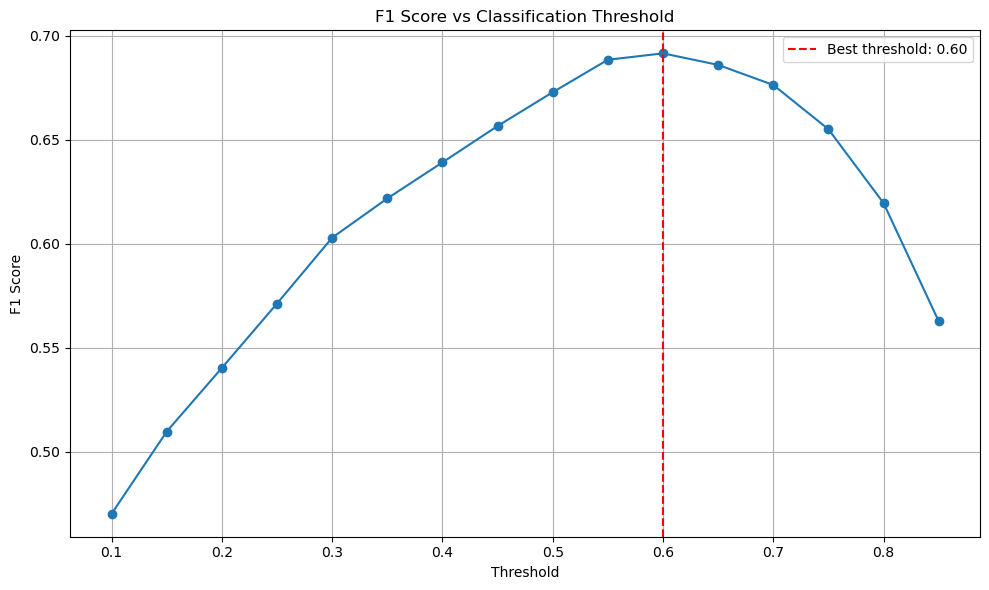

C:\Users\kostinkd\AppData\Local\Temp\ipykernel_24888\3867002020.py:261: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, plot_type="bar")


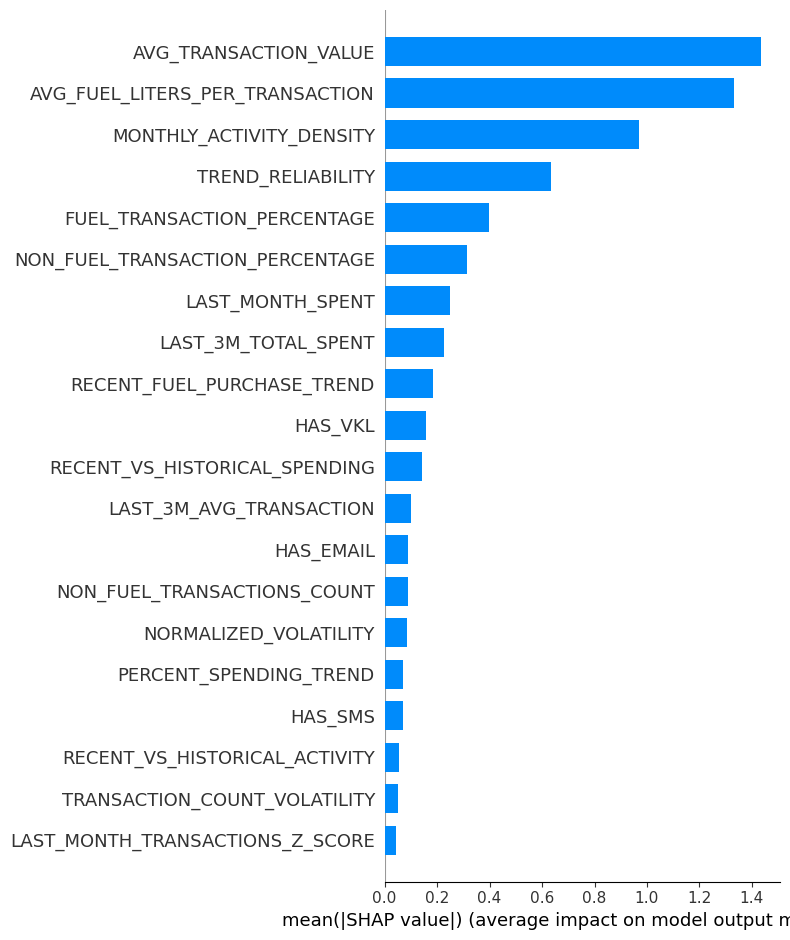

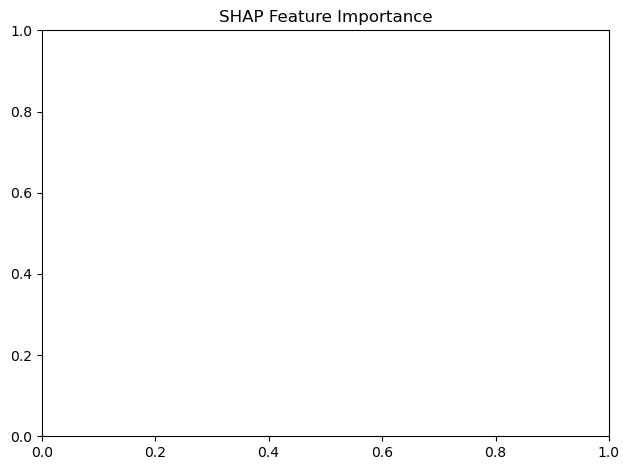

C:\Users\kostinkd\AppData\Local\Temp\ipykernel_24888\3867002020.py:267: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df)


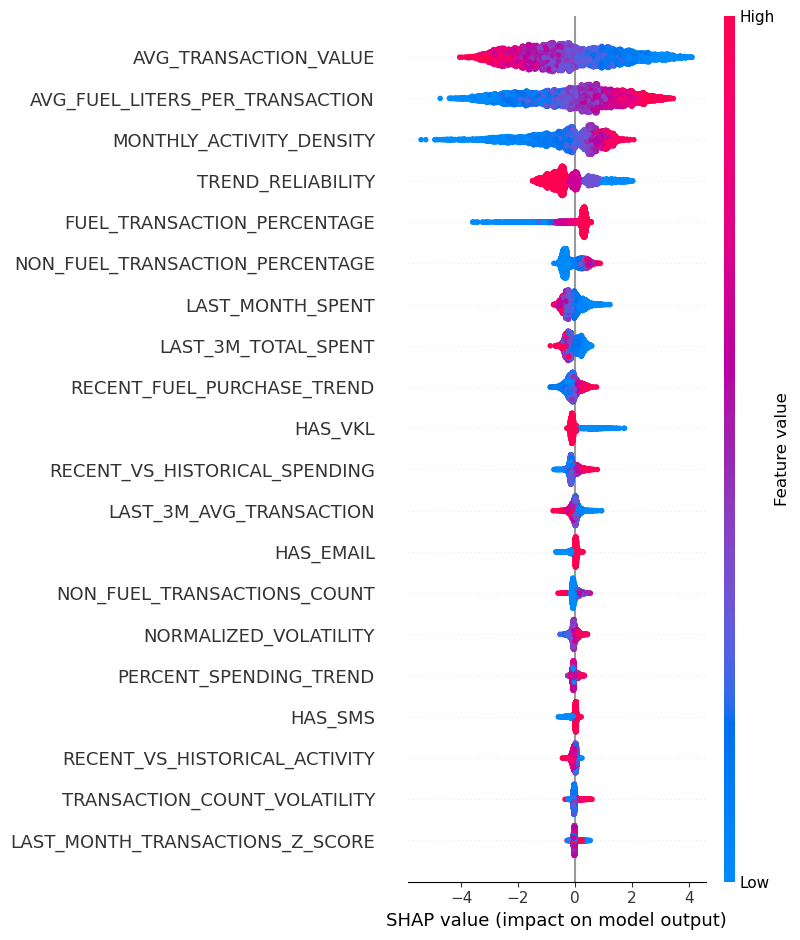

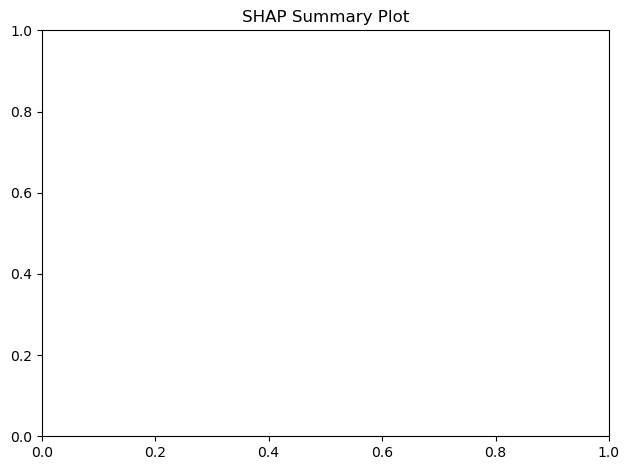


Top 10 features influencing churn:
                            Feature  Importance
3             AVG_TRANSACTION_VALUE    1.435105
35  AVG_FUEL_LITERS_PER_TRANSACTION    1.332049
19         MONTHLY_ACTIVITY_DENSITY    0.969140
27                TREND_RELIABILITY    0.634960
33      FUEL_TRANSACTION_PERCENTAGE    0.397249
34  NON_FUEL_TRANSACTION_PERCENTAGE    0.312192
8                  LAST_MONTH_SPENT    0.248442
11              LAST_3M_TOTAL_SPENT    0.225646
36       RECENT_FUEL_PURCHASE_TREND    0.184327
2                           HAS_VKL    0.157497


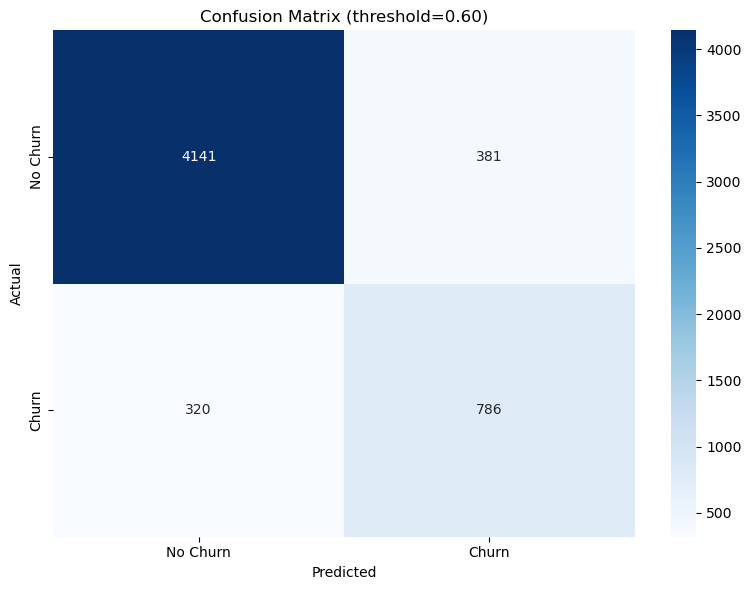


Classification Report (threshold=0.60):
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4522
           1       0.67      0.71      0.69      1106

    accuracy                           0.88      5628
   macro avg       0.80      0.81      0.81      5628
weighted avg       0.88      0.88      0.88      5628

Model Accuracy (threshold=0.60): 0.8754


In [35]:
# Select features (X) and target variable (y)
X = churn_features_df.select([col for col in churn_features_df.columns if col not in [
    "CHURN", "CLIENT_ID_SAP", "HAS_RECENT_INACTIVITY", "LATEST_TRANSACTION_DATE", "LAST_ACTIVE_MONTH", "MONTHS_SINCE_LAST_ACTIVITY",
    "ACTIVE_MONTHS", "MONTHS_AT_LEVEL", "CUSTOMER_TENURE_DAYS", "TOTAL_SPENT",
    "TOTAL_FUEL_LITERS", "TOTAL_TRANSACTIONS", "FUEL_TRANSACTIONS_COUNT", "LAST_TRANSACTION_DATE", "FIRST_ACTIVE_MONTH", "FIRST_TRANSACTION_DATE"
]])
y = churn_features_df.select("CHURN")

# Check class distribution
class_counts = y.select(pl.col("CHURN").value_counts()).sort("CHURN")
print("Class distribution:")
print(class_counts)

if len(class_counts) < 2:
    print("Error: Only one class present in the dataset. Cannot proceed with binary classification.")
else:
    # Split data into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X.to_pandas(),
        y.to_pandas(),
        test_size=0.2,
        random_state=42,
        stratify=y.to_pandas()
    )
    
    # Calculate scale_pos_weight to address class imbalance
    pos_weight = float((y_train['CHURN'] == 0).sum() / (y_train['CHURN'] == 1).sum())
    print(f"Scale pos weight: {pos_weight}")
    
    # Optuna Hyperparameter Optimization
    def objective(trial):
        # Define hyperparameters to optimize
        use_svd = trial.suggest_categorical('use_svd', [True, False])
        
        # SVD parameters (only used if use_svd is True)
        n_components_ratio = trial.suggest_float('n_components_ratio', 0.1, 0.9) if use_svd else 0.5
        
        # XGBoost parameters
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'seed': 42,
            'scale_pos_weight': pos_weight
        }
        
        # Prepare features with or without SVD
        if use_svd:
            # Calculate number of components (at least 2, at most n_features-1)
            max_components = min(X_train.shape[1] - 1, X_train.shape[0] - 1)
            n_components = max(2, min(int(n_components_ratio * max_components), max_components))
            
            try:
                # Apply TruncatedSVD for dimensionality reduction
                svd = TruncatedSVD(n_components=n_components, random_state=42)
                X_train_transformed = svd.fit_transform(X_train)
                explained_var = svd.explained_variance_ratio_.sum()
                print(f"Trial {trial.number}: Using SVD with {n_components} components, explained variance: {explained_var:.4f}")
                
                # Create DMatrix with transformed features
                dtrain = xgb.DMatrix(X_train_transformed, label=y_train['CHURN'])
            except Exception as e:
                print(f"SVD error: {e}, falling back to original features")
                dtrain = xgb.DMatrix(X_train, label=y_train['CHURN'])
                use_svd = False # Ensure use_svd is updated if SVD fails
        else:
            # Use original features
            dtrain = xgb.DMatrix(X_train, label=y_train['CHURN'])
        
        try:
            # Perform cross-validation
            cv_results = xgb.cv(
                params=params,
                dtrain=dtrain,
                num_boost_round=100,  # fewer rounds for faster evaluation
                nfold=3,
                stratified=True,
                early_stopping_rounds=5,
                metrics='auc',
                seed=42,
                verbose_eval=False
            )
            best_auc = cv_results['test-auc-mean'].max()
            best_round = cv_results['test-auc-mean'].argmax()
            
            # Store additional information in trial user attributes
            trial.set_user_attr('best_round', int(best_round))
            trial.set_user_attr('use_svd', use_svd) # Store the potentially updated use_svd status
            trial.set_user_attr('n_components', n_components if use_svd else 0)
            
            return best_auc
            
        except Exception as e:
            print(f"CV error in trial {trial.number}: {e}")
            return 0.5  # Default to random performance if error occurs
    
    # Create Optuna study
    print("Starting Optuna optimization...")
    study = optuna.create_study(direction='maximize', study_name='xgboost_churn_prediction')
    study.optimize(objective, n_trials=500, timeout=1800)  # 150 trials or 30 minutes, whichever comes first #тут поправил
    
    # Get best trial and parameters
    best_trial = study.best_trial
    best_params = best_trial.params
    print(f"\nBest trial: {best_trial.number}")
    print("Best hyperparameters found by Optuna:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    # Get additional information from the best trial
    use_svd = best_trial.user_attrs['use_svd']
    best_num_rounds = best_trial.user_attrs['best_round'] # This is the number of rounds from CV
    
    # Set final parameters using the best Optuna results
    final_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': best_params['max_depth'],
        'eta': best_params['eta'],
        'min_child_weight': best_params['min_child_weight'],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'seed': 42,
        'scale_pos_weight': pos_weight
    }
    
    print("\nFinal hyperparameters:")
    for key, value in final_params.items():
        print(f"{key}: {value}")
    print(f"use_svd: {use_svd}")
    
    # Prepare final features (with or without SVD) based on best trial
    if use_svd:
        n_components = best_trial.user_attrs['n_components']
        print(f"Using SVD with {n_components} components for final model")
        
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        X_train_final = svd.fit_transform(X_train)
        X_test_final = svd.transform(X_test)
        
        # Report explained variance
        explained_var = svd.explained_variance_ratio_.sum()
        print(f"SVD explained variance: {explained_var:.4f}")
        
        # Print the transformed feature shape
        print(f"Original feature shape: {X_train.shape}")
        print(f"Transformed feature shape: {X_train_final.shape}")
        
        # Create feature names for SVD components
        feature_names = [f"SVD_Component_{i+1}" for i in range(n_components)]
    else:
        X_train_final = X_train
        X_test_final = X_test
        feature_names = X_train.columns.tolist()
        print("Using original features (no SVD) for final model")
    
    # Final Model Training with Optimized Hyperparameters
    dtrain_final = xgb.DMatrix(X_train_final, label=y_train['CHURN'], feature_names=feature_names)
    dtest_final = xgb.DMatrix(X_test_final, label=y_test['CHURN'], feature_names=feature_names)
    
    # Train final model with more rounds and early stopping
    # The number of rounds from CV (best_num_rounds) can be a good starting point for num_boost_round,
    # but here we allow more rounds with early stopping for potentially better performance.
    print("\nTraining final model with optimized hyperparameters...")
    bst = xgb.train(
        final_params,
        dtrain_final,
        num_boost_round=300,  # Allow more rounds with early stopping
        evals=[(dtrain_final, 'train'), (dtest_final, 'eval')],
        early_stopping_rounds=10, # Stops if eval metric doesn't improve for 10 rounds
        verbose_eval=True
    )
    
    # Model Evaluation and SHAP Interpretability
    y_pred = bst.predict(dtest_final) # Probabilities
    auc_value = roc_auc_score(y_test['CHURN'], y_pred)
    print(f"\nFinal AUC: {auc_value:.4f}")
    
    # Find optimal classification threshold based on F1 score
    print("\nFinding optimal classification threshold...")
    thresholds = np.arange(0.1, 0.9, 0.05) # Range of thresholds to test
    f1_scores = []
    
    for threshold in thresholds:
        y_pred_binary_loop = (y_pred > threshold).astype(int)
        f1 = f1_score(y_test['CHURN'], y_pred_binary_loop)
        f1_scores.append(f1)
        print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")
    
    # Determine best threshold from the loop
    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    best_f1 = f1_scores[best_threshold_idx]
    
    print(f"\nOptimal threshold (manual search): {best_threshold:.2f} with F1 Score: {best_f1:.4f}")
    
    # Alternative approach: using precision-recall curve to find optimal threshold
    precision, recall, pr_thresholds = precision_recall_curve(y_test['CHURN'], y_pred)
    
    # Calculate F1 score for each threshold from PR curve (excluding the last precision/recall pair)
    f1_scores_pr = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)  # avoid division by zero
    
    # Find threshold with best F1 score from PR curve
    best_idx_pr = np.argmax(f1_scores_pr)
    # pr_thresholds has one less element than precision/recall
    best_threshold_pr = pr_thresholds[best_idx_pr] if best_idx_pr < len(pr_thresholds) else 0.5 
    
    print(f"Optimal threshold from PR curve: {best_threshold_pr:.4f} with F1 Score: {f1_scores_pr[best_idx_pr]:.4f}")
    
    # Plot F1 scores vs thresholds (from manual search)
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold (manual): {best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Classification Threshold (Manual Search)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Use the optimal threshold (from manual search, can be changed to best_threshold_pr if preferred) for final predictions
    y_pred_binary = (y_pred > best_threshold).astype(int)
    
    # SHAP analysis
    try:
        explainer = shap.TreeExplainer(bst)
        # Ensure dtest_final has feature names for SHAP if they were not passed during DMatrix creation
        # X_test_df is created below using X_test_final which should have correct dimensions
        shap_values = explainer.shap_values(X_test_final) # Pass numpy array or pandas DataFrame
        
        # Create DataFrame for SHAP plotting with appropriate feature names
        X_test_df_for_shap = pd.DataFrame(X_test_final, columns=feature_names)
        
        # SHAP summary plots
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_df_for_shap, plot_type="bar", show=False)
        plt.title("SHAP Feature Importance (Bar)")
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_df_for_shap, show=False)
        plt.title("SHAP Summary Plot (Dot)")
        plt.tight_layout()
        plt.show()
        
        # Calculate feature importance from SHAP values
        shap_feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Mean_Abs_SHAP_Value': np.abs(shap_values).mean(0)
        }).sort_values('Mean_Abs_SHAP_Value', ascending=False)
        
        print("\nTop 10 features influencing churn (based on SHAP values):")
        print(shap_feature_importance.head(10))
        
        # If SVD was used, show original feature contributions to top SVD components
        if use_svd:
            print("\nTop SVD components and their most important original features (from SVD model's components):")
            for i in range(min(3, n_components)): # Display for top 3 components or fewer if n_components < 3
                component_idx = i
                # svd.components_ shows the principal axes in the original feature space
                component_weights = pd.DataFrame({
                    'Original_Feature': X_train.columns, # Names of features before SVD
                    'Weight_in_SVD_Component': np.abs(svd.components_[component_idx])
                }).sort_values('Weight_in_SVD_Component', ascending=False)
                
                print(f"\nSVD_Component_{i+1} top original features by weight:")
                print(component_weights.head(5))
    except Exception as e:
        print(f"SHAP analysis error: {e}")
    
    # Prepare confusion matrix and classification report with the chosen optimal threshold
    conf_matrix = confusion_matrix(y_test['CHURN'], y_pred_binary)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (threshold={best_threshold:.2f})')
    plt.tight_layout()
    plt.show()
    
    # Classification metrics with optimal threshold
    print(f"\nClassification Report (threshold={best_threshold:.2f}):")
    print(classification_report(y_test['CHURN'], y_pred_binary))
    
    # Calculate accuracy with optimal threshold
    accuracy = accuracy_score(y_test['CHURN'], y_pred_binary)
    print(f"Model Accuracy (threshold={best_threshold:.2f}): {accuracy:.4f}")